# Examining Claims of Racial Bias in Predictive Policing through a

Geographic Perspective

Fareeza Ali and Jackson Howes (Georgetown University)

## Abstract

Predictive policing systems have been repeatedly criticized for reproducing and amplifying racial disparities, yet empirical evaluation is complicated by the fact that “crime data” are not neutral measurements of underlying criminal behavior but administrative records produced through enforcement, reporting, and institutional decision-making. In this manuscript, we assess whether spatial patterns in recorded violent felony incidents changed in ways consistent with the claim that algorithmic policing intensified racially disparate enforcement. We adopt a geographic perspective, using NYPD precincts as the unit of analysis, violent felony complaint records as the outcome, and census-derived racial composition as the principal demographic covariate. Our design compares a pre-period (2010–2012) and a post-period (2013–2019) bracketing the implementation window of Patternizr, a predictive policing system introduced by the NYPD in 2013. We quantify global spatial autocorrelation in both crime rates and Black population share using Moran’s $I$, identify local clusters using Local Indicators of Spatial Association (LISA), and assess whether observed clustering exceeds what would be expected under a population-proportional null model via Monte Carlo simulation. Finally, we use geographically weighted regression (GWR) to examine whether the relationship between racial composition and recorded crime rates became more spatially heterogeneous over time. We emphasize throughout that any observed differences are associational rather than causal, given concurrent neighborhood change and other confounds; nonetheless, this framework isolates concrete spatial signatures that are directly relevant to claims of algorithmically mediated bias.

## Introduction

Public and scholarly debates over predictive policing have increasingly centered on a shared concern: that algorithmic systems trained on historically patterned enforcement data may re-entrench and intensify the very disparities they purport to mitigate. In the specific context of New York City, Patternizr has been described as a tool intended to assist in recognizing potentially related crime patterns; however, even systems framed as investigative aids may shape enforcement attention and thereby the geography of recorded crime. When police deploy resources unevenly across space, administrative “crime” data can reflect both underlying incidents and the spatial distribution of policing itself. As a result, testing claims of algorithmic bias requires methodological approaches that can separate (or at minimum, describe) changes in spatial concentration and demographic overlap.

We therefore pose a geographically grounded question: did the spatial structure of recorded violent felony crime become more clustered after the implementation of Patternizr, and did the geography of those clusters align differently with the geography of Black residential concentration? Importantly, our inferential target is not a direct causal estimate of Patternizr’s effect. Instead, we evaluate whether the *spatial signatures* of recorded crime—global clustering, local hot spots, and hot-spot overlap with racially concentrated precincts—changed in ways that are consistent with common critiques of predictive policing. We explicitly treat demographic change, including gentrification and population redistribution between 2010 and 2020, as a major confound that must be described alongside any policing-related interpretation.

## Research Questions and Hypotheses

Our analysis is organized around three primary research questions.

1.  **Did the spatial clustering of violent felony *crime rates* change between the pre-Patternizr and post-Patternizr periods?** If predictive policing concentrated enforcement attention into a narrower set of precincts, we would expect increased spatial autocorrelation in recorded crime rates. This motivates comparison of global Moran’s $I$ for precinct-level crime rates across periods.

2.  **Did the spatial clustering of Black residential concentration change over the same window, and how does it relate to crime clustering?** Racial residential segregation produces strong spatial autocorrelation in demographic composition. If this structure is stable while crime clustering changes, then changes in the *relationship* between demographic clustering and crime clustering become substantively interpretable.

3.  **Did the overlap between crime hot spots and Black population hot spots change?** We operationalize “hot spot” using LISA High–High clusters. A reduction in overlap may indicate either (i) a weakening association between racial concentration and recorded crime hot spots, or (ii) demographic change in the precincts that previously occupied both categories.

In addition, we use geographically weighted regression (GWR) as a diagnostic to evaluate whether the local association between percent Black and precinct crime rates became more spatially heterogeneous over time. Substantively, a shift toward stronger spatial non-stationarity is consistent with a more localized policing geography, but this pattern can also arise from localized neighborhood change and other place-specific dynamics.

## Data and Study Design

### Setup and Load Libraries

In [ ]:
#| label: setup-libraries

library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   4.0.0     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Linking to GEOS 3.13.0, GDAL 3.8.5, PROJ 9.5.1; sf_use_s2() is TRUE

To enable caching of data, set `options(tigris_use_cache = TRUE)`
in your R script or .Rprofile.

Loading required package: spData

### Spatial Units and Coordinate Systems

The unit of analysis is each NYPD precinct. We load an official precinct boundary shapefile and project it to an equal-area / planar coordinate system appropriate for spatial operations (EPSG:32118). All spatial overlays and neighborhood constructions (contiguity weights) are conducted in this projected CRS to ensure that area calculations and adjacency relationships are well-defined.

In [ ]:
#| label: load-precincts

precincts <- st_read("../data/nyc_precincts.geojson", quiet = TRUE)
precincts_proj <- st_transform(precincts, 32118)

### Demographic Data: Census Blocks to Precincts via Areal Interpolation

Because precinct boundaries do not align with census block boundaries, we construct precinct-level demographics using areal interpolation. Specifically, we obtain census block geometries and block-level decennial census counts for 2010 and 2020. For each census year, we intersect census blocks with precinct polygons, compute the proportion of each block’s area contained within each precinct, and allocate block-level counts proportionally to those intersection weights. Summing the allocated counts across intersections yields precinct-level demographic totals.

Formally, let $b$ index census blocks and $p$ index precincts. Define the intersection area $A_{bp} = \text{area}(b \cap p)$ and block area $A_b = \text{area}(b)$. The areal weight is:

$$
w_{bp} = \frac{A_{bp}}{A_b}
$$

For a block-level count $X_b$ (e.g., total population, race counts), the precinct-allocated contribution from block $b$ is:

$$
X_{bp}^{\text{alloc}} = w_{bp} X_b
$$

and the precinct-level total is:

$$
X_p = \sum_{b} X_{bp}^{\text{alloc}}
$$

We then compute precinct demographic shares (e.g., percent Black) as:

$$
\%Black_p = 100 \times \frac{Black_p}{TotalPop_p}
$$

with analogous definitions for percent Hispanic and percent White.

This approach implicitly assumes uniform population density within each block. While imperfect, it is standard practice when translating census counts to non-nested administrative boundaries, and it produces internally consistent precinct-level denominators for per-capita crime rate computation.

#### 2020 Census Data Processing

In [ ]:
#| label: process-2020-census

# Load 2020 block geometries
blocks_2020 <- st_read("../data/tl_2020_36_tabblock20/tl_2020_36_tabblock20.shp", quiet = TRUE)

nyc_counties <- c("005", "047", "061", "081", "085")
blocks_2020_nyc <- blocks_2020 %>%
  filter(COUNTYFP20 %in% nyc_counties)

# Pull 2020 census data
p1_2020 <- get_decennial(
  geography = "block",
  variables = c("P1_001N", "P1_003N", "P1_004N", "P1_005N", 
                "P1_006N", "P1_007N", "P1_008N", "P1_009N"),
  state = "NY",
  county = nyc_counties,
  year = 2020,
  output = "wide"
)

Getting data from the 2020 decennial Census

Using the PL 94-171 Redistricting Data Summary File

Note: 2020 decennial Census data use differential privacy, a technique that
introduces errors into data to preserve respondent confidentiality.
ℹ Small counts should be interpreted with caution.
ℹ See https://www.census.gov/library/fact-sheets/2021/protecting-the-confidentiality-of-the-2020-census-redistricting-data.html for additional guidance.
This message is displayed once per session.

Getting data from the 2020 decennial Census
Using the PL 94-171 Redistricting Data Summary File

all geometries

ℹ In argument: `across(ends_with("_alloc"), sum, na.rm = TRUE)`.
ℹ In group 1: `precinct = "1"`.
Caused by warning:
! The `...` argument of `across()` is deprecated as of dplyr 1.1.0.
Supply arguments directly to `.fns` through an anonymous function instead.

  # Previously
  across(a:b, mean, na.rm = TRUE)

  # Now
  across(a:b, \(x) mean(x, na.rm = TRUE))

#### 2010 Census Data Processing

In [ ]:
#| label: process-2010-census

# Load 2010 block geometries
blocks_2010 <- blocks(state = "NY", county = nyc_counties, year = 2010)
blocks_2010_nyc <- blocks_2010 %>%
  filter(COUNTYFP10 %in% nyc_counties)

# Pull 2010 census data
p1_2010 <- get_decennial(
  geography = "block",
  variables = c("P003001", "P003002", "P003003", "P003004",
                "P003005", "P003006", "P003007", "P003008"),
  state = "NY",
  county = nyc_counties,
  year = 2010,
  output = "wide"
)

Getting data from the 2010 decennial Census

Using Census Summary File 1

Getting data from the 2010 decennial Census
Using Census Summary File 1

all geometries

#### Standardize Column Names

In [ ]:
#| label: standardize-columns

precincts_2010 <- precincts_2010 %>%
  rename(
    total_pop_alloc = P003001_alloc,
    white_alloc = P003002_alloc,
    black_alloc = P003003_alloc,
    aian_alloc = P003004_alloc,
    asian_alloc = P003005_alloc,
    nhpi_alloc = P003006_alloc,
    other_alloc = P003007_alloc,
    two_or_more_alloc = P003008_alloc,
    hispanic_total_alloc = P004001_alloc,
    hispanic_alloc = P004002_alloc,
    not_hispanic_alloc = P004003_alloc
  )

precincts_2020 <- precincts_2020 %>%
  rename(
    total_pop_alloc = P1_001N_alloc,
    white_alloc = P1_003N_alloc,
    black_alloc = P1_004N_alloc,
    aian_alloc = P1_005N_alloc,
    asian_alloc = P1_006N_alloc,
    nhpi_alloc = P1_007N_alloc,
    other_alloc = P1_008N_alloc,
    two_or_more_alloc = P1_009N_alloc,
    hispanic_total_alloc = P2_001N_alloc,
    hispanic_alloc = P2_002N_alloc,
    not_hispanic_alloc = P2_003N_alloc
  )

### Crime Data: Violent Felony Complaint Records

We load a cleaned violent felony complaint dataset from the city containing point locations (latitude/longitude) and complaint dates. Complaint points are converted into an `sf` point object in WGS84 (EPSG:4326) and then filtered to a bounding box corresponding to New York City to remove obvious geocoding errors. Points are subsequently projected into EPSG:32118 for spatial joins and distance-consistent operations. Complaint dates are parsed to extract year, enabling period-based subsetting.

In [ ]:
#| label: load-crime-data

violent_crimes <- read.csv("../data/violent_felony_cleaned_13.csv")

violent_sf <- st_as_sf(
  violent_crimes,
  coords = c("long", "lat"),
  crs = 4326
)

violent_sf <- violent_sf %>%
  filter(
    !is.na(geometry),
    sf::st_coordinates(geometry)[, 1] > -74.5,
    sf::st_coordinates(geometry)[, 1] < -73.7,
    sf::st_coordinates(geometry)[, 2] > 40.45,
    sf::st_coordinates(geometry)[, 2] < 40.95
  )

violent_proj <- st_transform(violent_sf, 32118)

violent_proj <- violent_proj %>%
  mutate(
    complaint_date = as.Date(complaint_date),
    year = as.integer(format(complaint_date, "%Y"))
  )

### Pre/Post Comparison Windows

To reduce transitional ambiguity surrounding the implementation timeline, we define two non-overlapping windows:

-   **Before**: 2010–2012
-   **After**: 2013–2019

For each period, we spatially join complaint points to precinct polygons, count incidents per precinct, and compute the precinct-level violent felony rate per 1,000 residents:

$$
CrimeRate_p = 1000 \times \frac{Crimes_p}{TotalPop_p}
$$

We exclude precinct 22 (Central Park) due to its negligible residential population, which otherwise induces artificially inflated per-capita rates and undermines interpretability.

In [ ]:
#| label: create-before-after-datasets

# Filter crimes by period
crimes_before <- violent_proj %>% filter(year >= 2010 & year <= 2012)
crimes_after <- violent_proj %>% filter(year >= 2013 & year <= 2019)

cat("Crimes before (2010-2012):", nrow(crimes_before), "\n")

Crimes before (2010-2012): 201231 

Crimes after (2013-2019): 412321 

Precincts remaining (before): 76 

Precincts remaining (after): 76 

In [ ]:
#| label: summary-stats

cat("=== BEFORE (excluding Central Park) ===\n")

=== BEFORE (excluding Central Park) ===

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  6.386  18.089  24.631  27.589  34.098 115.440 


=== AFTER (excluding Central Park) ===

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  11.23   30.41   47.22   52.28   67.38  191.28 

## Methods Overview

Our empirical strategy combines (i) global measures of spatial autocorrelation, (ii) local cluster detection, (iii) a simulation-based null model to benchmark observed clustering, and (iv) a spatially varying regression diagnostic. These components correspond directly to the computational workflow implemented below.

### Global Spatial Autocorrelation: Moran’s I

We quantify global spatial autocorrelation using Moran’s $I$ for two variables: (a) precinct crime rates and (b) percent Black population. Spatial dependence is defined using a queen contiguity neighborhood structure (shared edges or corners). Let $x_p$ denote a precinct-level variable (e.g., crime rate) and $\bar{x}$ its mean. With spatial weights $w_{pq}$ (row-standardized), Moran’s $I$ is:

$$
I = \frac{n}{S_0}\frac{\sum_{p}\sum_{q} w_{pq}(x_p - \bar{x})(x_q - \bar{x})}{\sum_{p}(x_p - \bar{x})^2}
$$

where $n$ is the number of precincts and $S_0 = \sum_{p}\sum_{q} w_{pq}$. We compute Moran’s $I$ separately for each period and interpret differences as changes in the degree of clustering in the precinct-level surfaces.

In [ ]:
#| label: create-spatial-weights

# Convert to sp objects for spdep
precincts_before_sp <- as(precincts_before, "Spatial")
precincts_after_sp <- as(precincts_after, "Spatial")

# Create queen contiguity neighbors (precincts sharing edges or corners)
nb_before <- poly2nb(precincts_before_sp, queen = TRUE)

Warning in poly2nb(precincts_before_sp, queen = TRUE): neighbour object has 3 sub-graphs;
if this sub-graph count seems unexpected, try increasing the snap argument.

Warning in poly2nb(precincts_after_sp, queen = TRUE): neighbour object has 3 sub-graphs;
if this sub-graph count seems unexpected, try increasing the snap argument.

Spatial weights created successfully

Average # of neighbors (before): 4.18 

Average # of neighbors (after): 4.18 

In [ ]:
#| label: morans-i-crime-rate

cat("========== GLOBAL MORAN'S I: CRIME RATE ==========\n\n")

========== GLOBAL MORAN'S I: CRIME RATE ==========

--- BEFORE (2010-2012) ---


    Moran I test under randomisation

data:  precincts_before$crime_rate  
weights: weights_before    

Moran I statistic standard deviate = 3.7442, p-value = 9.047e-05
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      0.269439611      -0.013333333       0.005703561 


--- AFTER (2013-2019) ---


    Moran I test under randomisation

data:  precincts_after$crime_rate  
weights: weights_after    

Moran I statistic standard deviate = 4.3169, p-value = 7.911e-06
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      0.325313015      -0.013333333       0.006153788 

In [ ]:
#| label: morans-i-pct-black

cat("========== GLOBAL MORAN'S I: PCT BLACK ==========\n\n")

========== GLOBAL MORAN'S I: PCT BLACK ==========

--- BEFORE (2010-2012) ---


    Moran I test under randomisation

data:  precincts_before$pct_black  
weights: weights_before    

Moran I statistic standard deviate = 7.1848, p-value = 3.366e-13
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      0.570490119      -0.013333333       0.006602919 


--- AFTER (2013-2019) ---


    Moran I test under randomisation

data:  precincts_after$pct_black  
weights: weights_after    

Moran I statistic standard deviate = 7.0478, p-value = 9.092e-13
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      0.557878445      -0.013333333       0.006568909 

In [ ]:
#| label: morans-summary-table

moran_summary <- data.frame(
  Variable = c("Crime Rate", "Crime Rate", "Pct Black", "Pct Black"),
  Period = c("Before", "After", "Before", "After"),
  Morans_I = c(
    moran_crime_before$estimate["Moran I statistic"],
    moran_crime_after$estimate["Moran I statistic"],
    moran_black_before$estimate["Moran I statistic"],
    moran_black_after$estimate["Moran I statistic"]
  ),
  P_Value = c(
    moran_crime_before$p.value,
    moran_crime_after$p.value,
    moran_black_before$p.value,
    moran_black_after$p.value
  )
)

cat("========== MORAN'S I SUMMARY ==========\n")

========== MORAN'S I SUMMARY ==========

    Variable Period  Morans_I      P_Value
1 Crime Rate Before 0.2694396 9.046675e-05
2 Crime Rate  After 0.3253130 7.910665e-06
3  Pct Black Before 0.5704901 3.365746e-13
4  Pct Black  After 0.5578784 9.091641e-13

### Local Moran’s I and LISA Cluster Typology

To identify localized clusters and spatial outliers, we compute Local Moran’s $I$ (LISA) for both crime rates and percent Black. We classify each precinct into one of five categories based on the sign of its standardized value and the sign of its spatial lag (neighbors’ average), conditional on statistical significance:

-   High–High (hot spot): high value surrounded by high values
-   Low–Low (cold spot): low value surrounded by low values
-   High–Low: high outlier surrounded by low values
-   Low–High: low outlier surrounded by high values
-   Not significant

The key substantive comparison is whether High–High crime precincts co-occur with High–High Black precincts, and whether the count (and identity) of overlapping precincts changes from the pre-period to the post-period.

In [ ]:
#| label: lisa-analysis

# Compute Local Moran's I
lisa_crime_before <- localmoran(precincts_before$crime_rate, weights_before)
lisa_black_before <- localmoran(precincts_before$pct_black, weights_before)
lisa_crime_after <- localmoran(precincts_after$crime_rate, weights_after)
lisa_black_after <- localmoran(precincts_after$pct_black, weights_after)

# Function to classify LISA clusters
get_lisa_clusters <- function(variable, lisa_output, weights) {
  z <- scale(variable)[,1]
  lag_z <- lag.listw(weights, z)
  p_value <- lisa_output[, 5]
  
  cluster <- case_when(
    p_value > 0.05 ~ "Not Significant",
    z > 0 & lag_z > 0 ~ "High-High",
    z < 0 & lag_z < 0 ~ "Low-Low",
    z > 0 & lag_z < 0 ~ "High-Low",
    z < 0 & lag_z > 0 ~ "Low-High",
    TRUE ~ "Not Significant"
  )
  
  return(cluster)
}

# Apply to all four combinations
precincts_before$lisa_crime <- get_lisa_clusters(
  precincts_before$crime_rate, lisa_crime_before, weights_before
)
precincts_before$lisa_black <- get_lisa_clusters(
  precincts_before$pct_black, lisa_black_before, weights_before
)
precincts_after$lisa_crime <- get_lisa_clusters(
  precincts_after$crime_rate, lisa_crime_after, weights_after
)
precincts_after$lisa_black <- get_lisa_clusters(
  precincts_after$pct_black, lisa_black_after, weights_after
)

In [ ]:
#| label: lisa-summary

cat("=== LISA Clusters: CRIME RATE ===\n")

=== LISA Clusters: CRIME RATE ===

BEFORE:


      High-High        Low-High         Low-Low Not Significant 
              6               1               1              68 


AFTER:


      High-High        Low-High         Low-Low Not Significant 
              5               1               1              69 


=== LISA Clusters: PCT BLACK ===

BEFORE:


      High-High        Low-High         Low-Low Not Significant 
              7               2               2              65 


AFTER:


      High-High         Low-Low Not Significant 
              6               1              69 

In [ ]:
#| label: lisa-overlap

cat("=== OVERLAP: High-High Crime AND High-High Black ===\n\n")

=== OVERLAP: High-High Crime AND High-High Black ===

BEFORE - Precincts that are High-High for BOTH crime and Black population:

  precinct crime_rate pct_black
1       73   62.52496  81.73487
2       77   39.89329  72.30491
3       81   57.68057  80.20771

Count: 3 

AFTER - Precincts that are High-High for BOTH crime and Black population:

[1] precinct   crime_rate pct_black 
<0 rows> (or 0-length row.names)

Count: 0 

In [ ]:
#| label: lisa-crosstab

cat("=== Full Cross-Tabulation: Crime Clusters vs Black Clusters ===\n\n")

=== Full Cross-Tabulation: Crime Clusters vs Black Clusters ===

BEFORE:

                 
                  High-High Low-High Low-Low Not Significant
  High-High               3        1       0               2
  Low-High                0        0       0               1
  Low-Low                 0        0       1               0
  Not Significant         4        1       1              62


AFTER:

                 
                  High-High Low-Low Not Significant
  High-High               0       0               5
  Low-High                0       0               1
  Low-Low                 0       1               0
  Not Significant         6       0              63

In [ ]:
#| label: track-precincts

track_precincts <- c("73", "77", "81")

cat("=== Tracking Precincts 73, 77, 81 ===\n\n")

=== Tracking Precincts 73, 77, 81 ===

BEFORE (2010-2012):

  precinct total_crimes crime_rate pct_black lisa_crime lisa_black
1       73         5411   62.52496  81.73487  High-High  High-High
2       77         3597   39.89329  72.30491  High-High  High-High
3       81         3621   57.68057  80.20771  High-High  High-High


AFTER (2013-2019):

  precinct total_crimes crime_rate pct_black      lisa_crime      lisa_black
1       73        11034  111.95594  71.84071 Not Significant       High-High
2       77         6996   69.09301  50.39772 Not Significant       High-High
3       81         6978  101.23460  58.09961 Not Significant Not Significant


=== Which precincts are High-High for crime AFTER? ===

  precinct crime_rate pct_black      lisa_black
1       40  111.83831  34.22379 Not Significant
2       41  149.35706  30.28773 Not Significant
3       42   84.09862  45.89912 Not Significant
4       43   57.14626  31.27506 Not Significant
5       44   74.37054  33.84694 Not Significant


=== Which precincts are High-High for Black pop AFTER? ===

  precinct crime_rate pct_black      lisa_crime
1       67   63.86813  80.40893 Not Significant
2       63   31.22853  43.82666 Not Significant
3       69   49.08681  81.46211 Not Significant
4       73  111.95594  71.84071 Not Significant
5       77   69.09301  50.39772 Not Significant
6      100   47.37379  24.78987 Not Significant

### Monte Carlo Null Model for Crime Clustering

Global Moran’s $I$ can be statistically significant even under modest clustering when sample sizes are large; more importantly, observed clustering may reflect population distribution rather than any additional geographic process. We therefore implement a Monte Carlo simulation under a population-proportional null:

-   The total number of crimes observed in a period is held fixed.
-   Crimes are randomly allocated to precincts with probability proportional to precinct population.
-   Simulated crime rates are computed and Moran’s $I$ is evaluated for each simulation.

Let $C$ be the observed number of crimes in a period and $p_p = \frac{Pop_p}{\sum_q Pop_q}$. A single simulation draws precinct crime counts:

$$
(C_1,\ldots,C_n) \sim \text{Multinomial}\left(C; p_1,\ldots,p_n\right)
$$

and constructs simulated rates $CrimeRate_p^{(s)} = 1000 \times \frac{C_p}{Pop_p}$. Repeating this process yields an empirical null distribution of Moran’s $I$. We compute the Monte Carlo p-value as the proportion of simulated Moran’s $I$ values greater than or equal to the observed $I$ (with a standard +1 correction):

$$
p = \frac{\#\{I^{(s)} \ge I^{obs}\} + 1}{S + 1}
$$

where $S$ is the number of simulations.

In [ ]:
#| label: monte-carlo-function

set.seed(65)

simulate_morans_i <- function(precincts_df, weights, n_sims = 999) {
  total_crimes <- sum(precincts_df$total_crimes)
  populations <- precincts_df$total_pop_alloc
  total_pop <- sum(populations)
  pop_proportions <- populations / total_pop
  sim_morans <- numeric(n_sims)
  
  for (i in 1:n_sims) {
    sim_crimes <- rmultinom(1, size = total_crimes, prob = pop_proportions)[,1]
    sim_rate <- (sim_crimes / populations) * 1000
    sim_rate[is.infinite(sim_rate)] <- 0
    sim_moran <- moran(sim_rate, weights, n = length(sim_rate), S0 = Szero(weights))
    sim_morans[i] <- sim_moran$I
    
    if (i %% 100 == 0) {
      cat("Completed", i, "of", n_sims, "simulations\n")
    }
  }
  
  return(sim_morans)
}

In [ ]:
#| label: monte-carlo-before

cat("\n========== BEFORE PERIOD SIMULATION ==========\n")


========== BEFORE PERIOD SIMULATION ==========

Observed Moran's I (Before): 0.2694 

Running 999 simulations under null hypothesis...

Completed 100 of 999 simulations
Completed 200 of 999 simulations
Completed 300 of 999 simulations
Completed 400 of 999 simulations
Completed 500 of 999 simulations
Completed 600 of 999 simulations
Completed 700 of 999 simulations
Completed 800 of 999 simulations
Completed 900 of 999 simulations


Simulation Results (Before):

  Mean simulated Moran's I: -0.0133 

  SD simulated Moran's I: 0.0875 

  Observed Moran's I: 0.2694 

  Monte Carlo p-value: 0.003 

In [ ]:
#| label: monte-carlo-after

cat("\n========== AFTER PERIOD SIMULATION ==========\n")


========== AFTER PERIOD SIMULATION ==========

Observed Moran's I (After): 0.3253 

Running 999 simulations under null hypothesis...

Completed 100 of 999 simulations
Completed 200 of 999 simulations
Completed 300 of 999 simulations
Completed 400 of 999 simulations
Completed 500 of 999 simulations
Completed 600 of 999 simulations
Completed 700 of 999 simulations
Completed 800 of 999 simulations
Completed 900 of 999 simulations


Simulation Results (After):

  Mean simulated Moran's I: -0.0104 

  SD simulated Moran's I: 0.0851 

  Observed Moran's I: 0.3253 

  Monte Carlo p-value: 0.002 

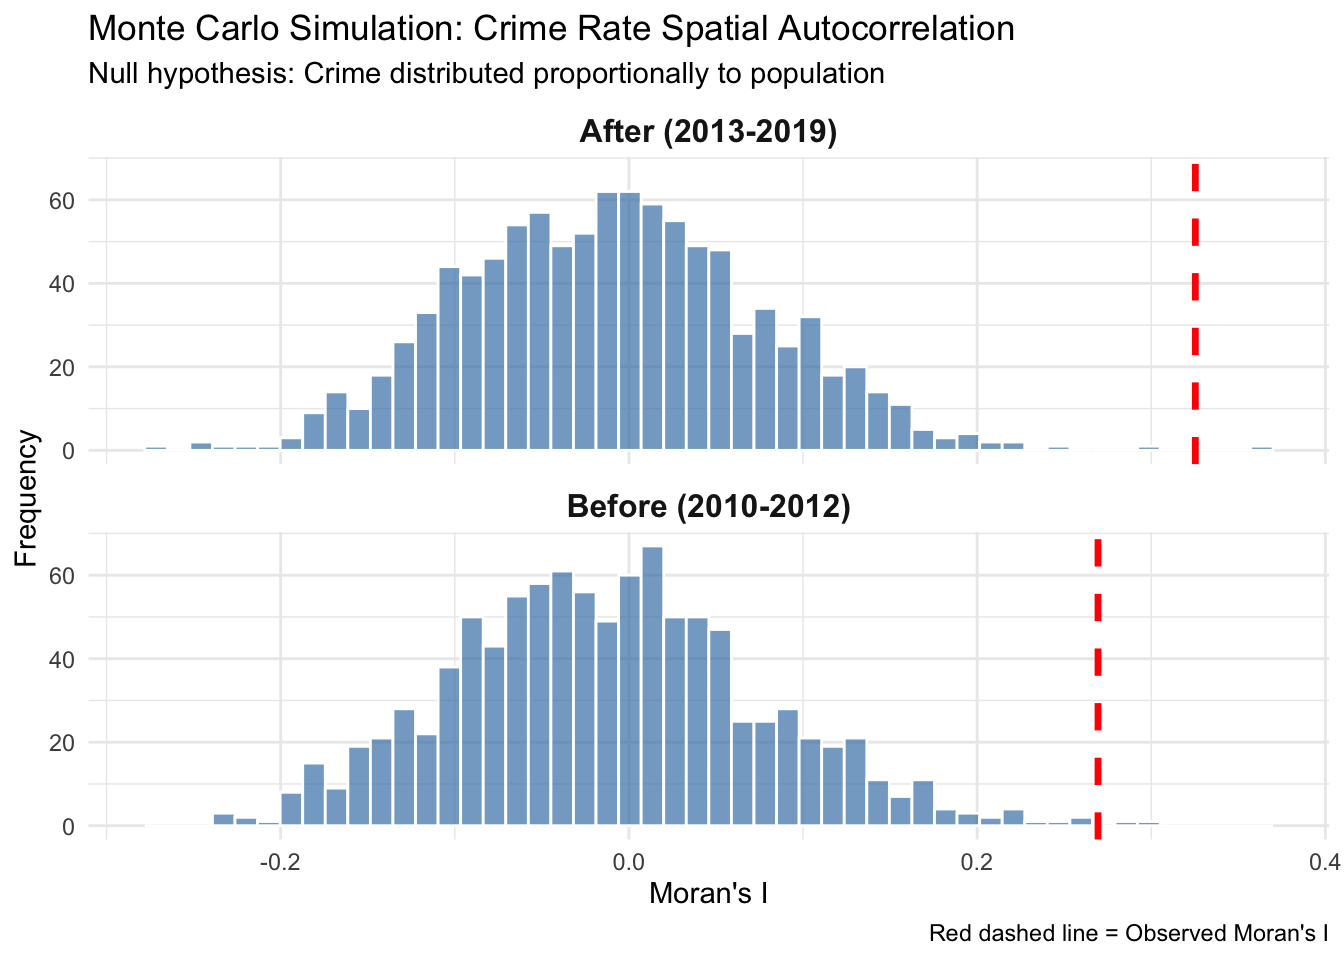

In [ ]:
#| label: monte-carlo-plot

sim_df <- data.frame(
  Morans_I = c(sim_morans_before, sim_morans_after),
  Period = rep(c("Before (2010-2012)", "After (2013-2019)"), each = 999)
)

observed_df <- data.frame(
  Morans_I = c(observed_moran_before, observed_moran_after),
  Period = c("Before (2010-2012)", "After (2013-2019)")
)

monte_carlo_plot <- ggplot(sim_df, aes(x = Morans_I)) +
  geom_histogram(bins = 50, fill = "steelblue", alpha = 0.7, color = "white") +
  geom_vline(data = observed_df, aes(xintercept = Morans_I), 
             color = "red", linetype = "dashed", linewidth = 1.2) +
  facet_wrap(~Period, ncol = 1) +
  theme_minimal() +
  labs(
    title = "Monte Carlo Simulation: Crime Rate Spatial Autocorrelation",
    subtitle = "Null hypothesis: Crime distributed proportionally to population",
    x = "Moran's I",
    y = "Frequency",
    caption = "Red dashed line = Observed Moran's I"
  ) +
  theme(strip.text = element_text(size = 12, face = "bold"))

print(monte_carlo_plot)

In [ ]:
#| label: monte-carlo-summary

mc_summary <- data.frame(
  Period = c("Before (2010-2012)", "After (2013-2019)"),
  Observed_Morans_I = c(observed_moran_before, observed_moran_after),
  Mean_Simulated = c(mean(sim_morans_before), mean(sim_morans_after)),
  SD_Simulated = c(sd(sim_morans_before), sd(sim_morans_after)),
  P_Value = c(p_value_before, p_value_after)
)

cat("========== MONTE CARLO SUMMARY ==========\n")

========== MONTE CARLO SUMMARY ==========

              Period Observed_Morans_I Mean_Simulated SD_Simulated P_Value
1 Before (2010-2012)         0.2694396    -0.01333626   0.08746933   0.003
2  After (2013-2019)         0.3253130    -0.01042705   0.08507049   0.002


========== INTERPRETATION ==========

BEFORE: Reject null hypothesis - crime is MORE clustered than expected under population-proportional distribution (p = 0.003 )

AFTER: Reject null hypothesis - crime is MORE clustered than expected under population-proportional distribution (p = 0.002 )

### Geographically Weighted Regression

Finally, we fit geographically weighted regression (GWR) models in each period to assess spatial non-stationarity in the association between racial composition and crime rates. For precinct $p$ with coordinates $(u_p, v_p)$, GWR estimates location-specific coefficients:

$$
CrimeRate_p = \beta_0(u_p,v_p) + \beta_1(u_p,v_p)\%Black_p + \beta_2(u_p,v_p)\%Hispanic_p + \beta_3(u_p,v_p)\%White_p + \varepsilon_p
$$

An adaptive bandwidth is selected via the standard GWR bandwidth selection routine, and local coefficients (particularly $\beta_1(u_p,v_p)$) are mapped for visual comparison across periods. This component is explicitly diagnostic: changes in coefficient heterogeneity can reflect shifts in policing geography, demographic change, or other local dynamics; thus, results are interpreted as evidence of spatial variation rather than causal impact.

In [ ]:
#| label: gwr-analysis

library(spgwr)

Loading required package: sp

NOTE: This package does not constitute approval of GWR
as a method of spatial analysis; see example(gwr)

=== Fitting GWR for BEFORE period ===

Warning in gwr.sel(crime_rate ~ pct_black + pct_hispanic + pct_white, data =
precincts_sp_before, : data is Spatial* object, ignoring coords argument

Adaptive q: 0.381966 CV score: 14999.83 
Adaptive q: 0.618034 CV score: 15097.84 
Adaptive q: 0.236068 CV score: 15085.6 
Adaptive q: 0.4209454 CV score: 15005.67 
Adaptive q: 0.382664 CV score: 15000.59 
Adaptive q: 0.3262379 CV score: 15015.89 
Adaptive q: 0.3606798 CV score: 15022.54 
Adaptive q: 0.3738354 CV score: 15010.12 
Adaptive q: 0.3788604 CV score: 15003.06 
Adaptive q: 0.3813392 CV score: 14999.72 
Adaptive q: 0.3815285 CV score: 14999.47 
Adaptive q: 0.3816274 CV score: 14999.45 
Adaptive q: 0.3816681 CV score: 14999.5 
Adaptive q: 0.3815867 CV score: 14999.41 
Adaptive q: 0.3815867 CV score: 14999.41 

Optimal adaptive bandwidth (Before): 0.382 

Warning in gwr(crime_rate ~ pct_black + pct_hispanic + pct_white, data =
precincts_sp_before, : data is Spatial* object, ignoring coords argument

Call:
gwr(formula = crime_rate ~ pct_black + pct_hispanic + pct_white, 
    data = precincts_sp_before, coords = coords_before, adapt = bw_before, 
    hatmatrix = TRUE)
Kernel function: gwr.Gauss 
Adaptive quantile: 0.3815867 (about 29 of 76 data points)
Summary of GWR coefficient estimates at data points:
                   Min.    1st Qu.     Median    3rd Qu.       Max.  Global
X.Intercept. 28.7125865 30.2015845 31.6285635 32.4752874 34.2351855 32.1571
pct_black     0.2328434  0.2780089  0.3176021  0.3579805  0.4033567  0.3097
pct_hispanic -0.2523239 -0.2034498 -0.1544861 -0.1023741 -0.0356422 -0.1718
pct_white    -0.1112431 -0.0608376 -0.0064229  0.0408800  0.0943873 -0.0113
Number of data points: 76 
Effective number of parameters (residual: 2traceS - traceS'S): 8.473558 
Effective degrees of freedom (residual: 2traceS - traceS'S): 67.52644 
Sigma (residual: 2traceS - traceS'S): 13.77924 
Effective number of parameters (model: traceS): 6.733035 
Effective degrees of freedom (mode


=== Fitting GWR for AFTER period ===

Warning in gwr.sel(crime_rate ~ pct_black + pct_hispanic + pct_white, data =
precincts_sp_after, : data is Spatial* object, ignoring coords argument

Adaptive q: 0.381966 CV score: 48175.64 
Adaptive q: 0.618034 CV score: 49126.83 
Adaptive q: 0.236068 CV score: 46703.21 
Adaptive q: 0.145898 CV score: 45577.51 
Adaptive q: 0.09016994 CV score: 43538.98 
Adaptive q: 0.05572809 CV score: 39851.21 
Adaptive q: 0.03444185 CV score: 36840.96 
Adaptive q: 0.02128624 CV score: 36701.45 
Adaptive q: 0.02646805 CV score: 36922.68 
Adaptive q: 0.01315562 CV score: 40241.2 
Adaptive q: 0.01818062 CV score: 37380.23 
Adaptive q: 0.02326551 CV score: 36675.14 
Adaptive q: 0.02538445 CV score: 36822.93 
Adaptive q: 0.02260392 CV score: 36659.83 
Adaptive q: 0.02251629 CV score: 36659.38 
Adaptive q: 0.02245394 CV score: 36659.31 
Adaptive q: 0.02241325 CV score: 36659.38 
Adaptive q: 0.02245394 CV score: 36659.31 

Optimal adaptive bandwidth (After): 0.022 

Warning in gwr(crime_rate ~ pct_black + pct_hispanic + pct_white, data =
precincts_sp_after, : data is Spatial* object, ignoring coords argument

Call:
gwr(formula = crime_rate ~ pct_black + pct_hispanic + pct_white, 
    data = precincts_sp_after, coords = coords_after, adapt = bw_after, 
    hatmatrix = TRUE)
Kernel function: gwr.Gauss 
Adaptive quantile: 0.02245394 (about 1 of 76 data points)
Summary of GWR coefficient estimates at data points:
                   Min.    1st Qu.     Median    3rd Qu.       Max. Global
X.Intercept. -322.72792  -77.75389   -5.74549   34.18227  541.57804 9.3732
pct_black      -3.74664    0.81629    1.26496    2.13543   18.17959 0.8241
pct_hispanic   -8.50157    0.19041    0.83417    1.77788    3.85127 0.6552
pct_white      -6.37656   -0.26404    0.31961    0.77214    4.35870 0.1583
Number of data points: 76 
Effective number of parameters (residual: 2traceS - traceS'S): 49.81015 
Effective degrees of freedom (residual: 2traceS - traceS'S): 26.18985 
Sigma (residual: 2traceS - traceS'S): 12.98531 
Effective number of parameters (model: traceS): 39.23732 
Effective degrees of freedom (model: trace

In [ ]:
#| label: gwr-coefficients

# Extract coefficients from GWR results
gwr_coefs_before <- as.data.frame(gwr_before$SDF)
gwr_coefs_after <- as.data.frame(gwr_after$SDF)

# Add to sf objects
precincts_gwr_before$gwr_pct_black <- gwr_coefs_before$pct_black
precincts_gwr_before$gwr_intercept <- gwr_coefs_before$`(Intercept)`
precincts_gwr_before$gwr_localR2 <- gwr_coefs_before$localR2

precincts_gwr_after$gwr_pct_black <- gwr_coefs_after$pct_black
precincts_gwr_after$gwr_intercept <- gwr_coefs_after$`(Intercept)`
precincts_gwr_after$gwr_localR2 <- gwr_coefs_after$localR2

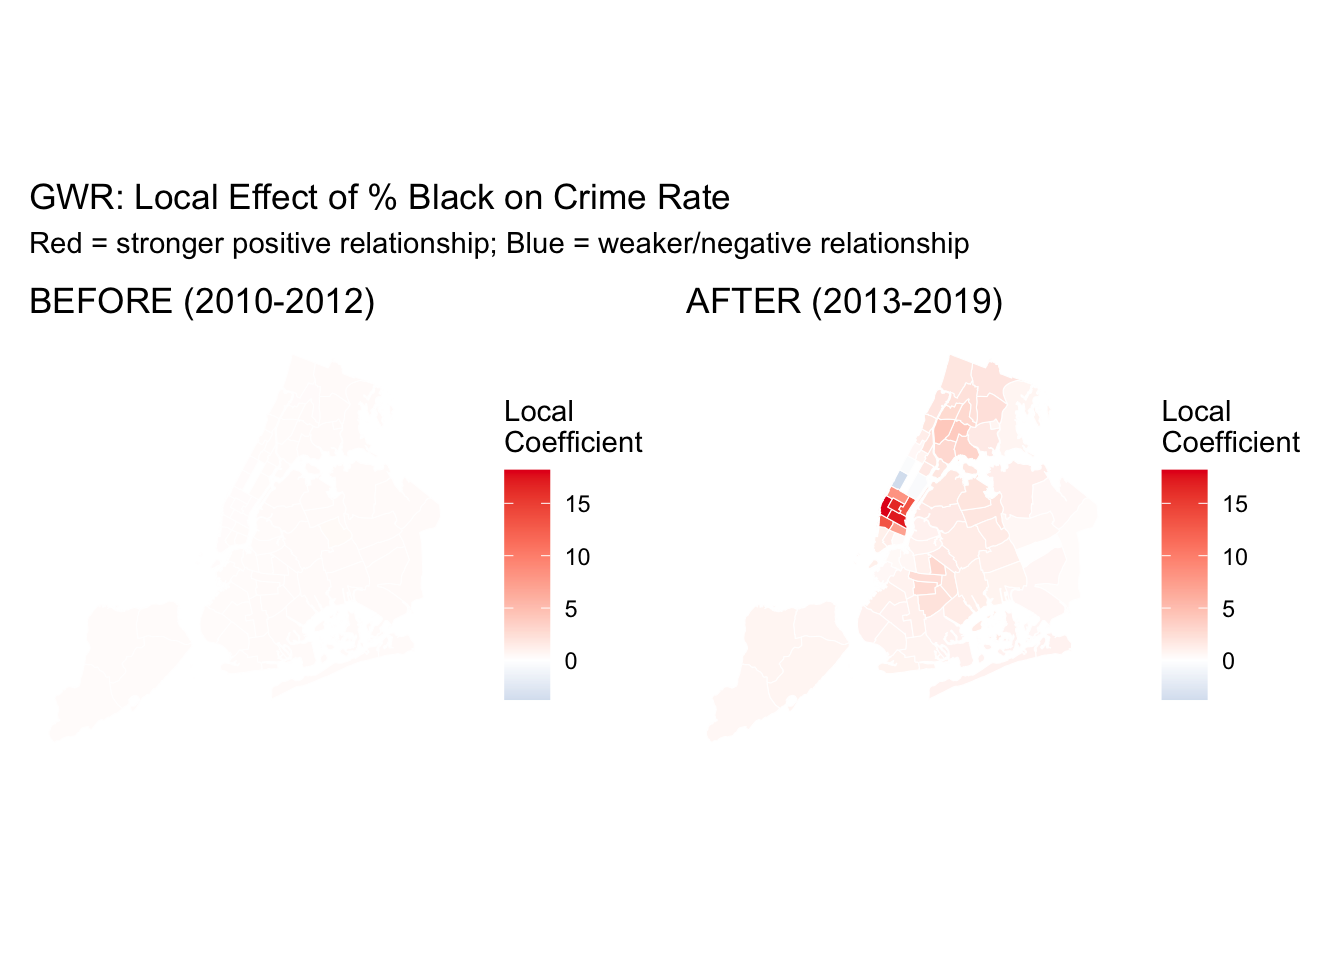

In [ ]:
#| label: gwr-maps

# Get consistent color scale
coef_range <- range(c(precincts_gwr_before$gwr_pct_black, precincts_gwr_after$gwr_pct_black))

gwr_map_before <- ggplot(precincts_gwr_before) +
  geom_sf(aes(fill = gwr_pct_black), color = "white", linewidth = 0.2) +
  scale_fill_gradient2(
    low = "#377EB8",
    mid = "white",
    high = "#E41A1C",
    midpoint = 0,
    name = "Local\nCoefficient",
    limits = coef_range
  ) +
  theme_minimal() +
  labs(title = "BEFORE (2010-2012)") +
  theme(
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank()
  )

gwr_map_after <- ggplot(precincts_gwr_after) +
  geom_sf(aes(fill = gwr_pct_black), color = "white", linewidth = 0.2) +
  scale_fill_gradient2(
    low = "#377EB8",
    mid = "white",
    high = "#E41A1C",
    midpoint = 0,
    name = "Local\nCoefficient",
    limits = coef_range
  ) +
  theme_minimal() +
  labs(title = "AFTER (2013-2019)") +
  theme(
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank()
  )

gwr_comparison <- gwr_map_before + gwr_map_after +
  plot_annotation(
    title = "GWR: Local Effect of % Black on Crime Rate",
    subtitle = "Red = stronger positive relationship; Blue = weaker/negative relationship"
  )

print(gwr_comparison)

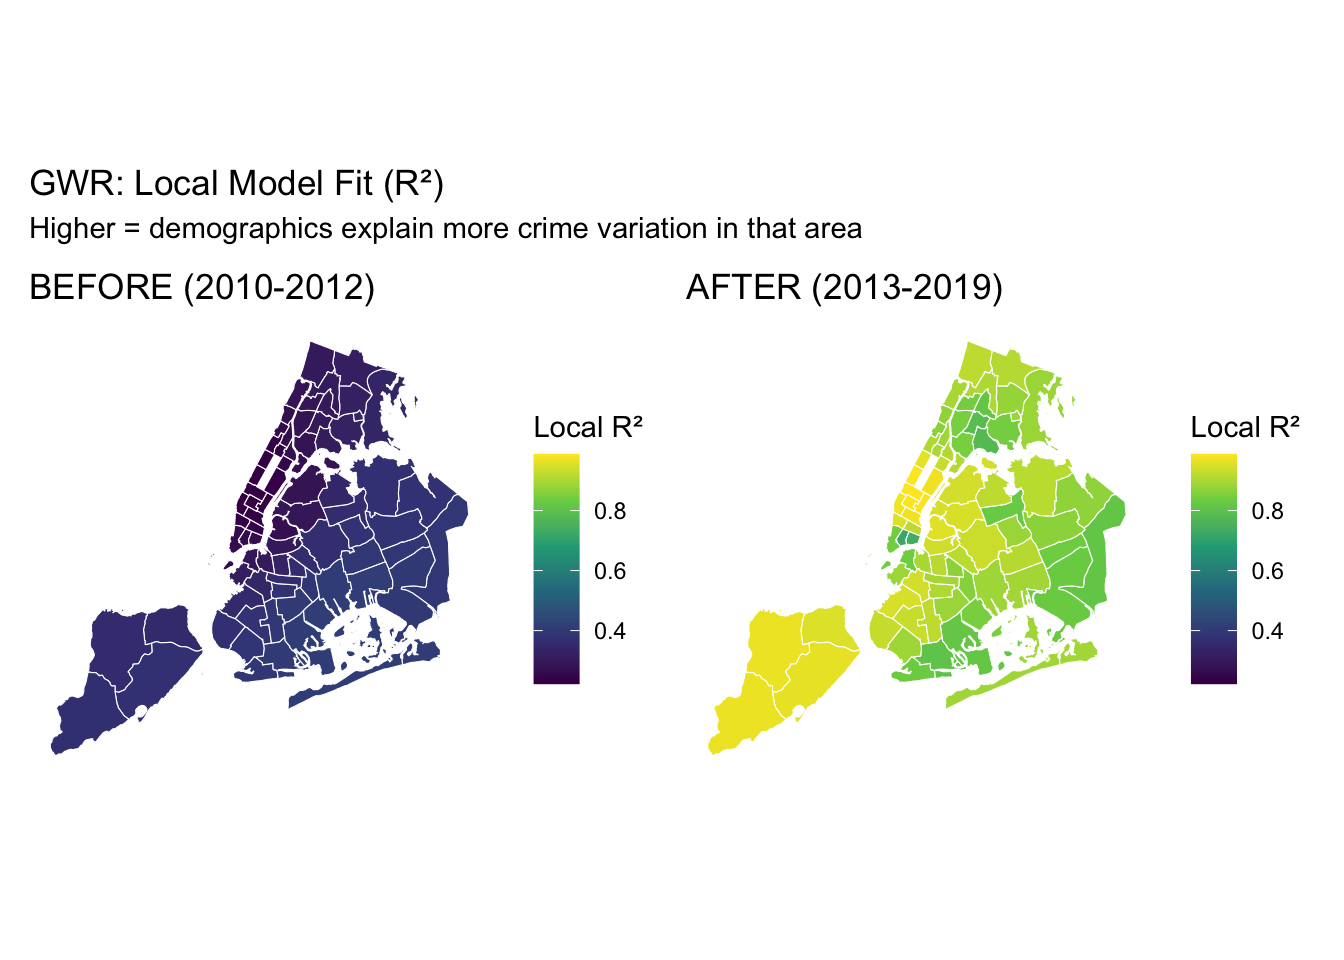

In [ ]:
#| label: gwr-r2-maps

r2_range <- range(c(precincts_gwr_before$gwr_localR2, precincts_gwr_after$gwr_localR2))

r2_map_before <- ggplot(precincts_gwr_before) +
  geom_sf(aes(fill = gwr_localR2), color = "white", linewidth = 0.2) +
  scale_fill_viridis_c(name = "Local R²", limits = r2_range) +
  theme_minimal() +
  labs(title = "BEFORE (2010-2012)") +
  theme(
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank()
  )

r2_map_after <- ggplot(precincts_gwr_after) +
  geom_sf(aes(fill = gwr_localR2), color = "white", linewidth = 0.2) +
  scale_fill_viridis_c(name = "Local R²", limits = r2_range) +
  theme_minimal() +
  labs(title = "AFTER (2013-2019)") +
  theme(
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank()
  )

r2_comparison <- r2_map_before + r2_map_after +
  plot_annotation(
    title = "GWR: Local Model Fit (R²)",
    subtitle = "Higher = demographics explain more crime variation in that area"
  )

print(r2_comparison)

In [ ]:
#| label: gwr-summary

cat("\n=== GWR Local Coefficient Summary: pct_black ===\n")


=== GWR Local Coefficient Summary: pct_black ===


BEFORE period:

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.2328  0.2780  0.3176  0.3183  0.3580  0.4034 


AFTER period:

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-3.7466  0.8163  1.2650  2.4041  2.1354 18.1796 


=== GWR ANALYSIS COMPLETE ===

## Results

### Global spatial autocorrelation

Violent felony crime rates exhibit statistically meaningful positive spatial autocorrelation in both periods. Before Patternizr, the Global Moran’s I for precinct crime rate was $I = 0.269$, indicating moderate spatial clustering. In the post-Patternizr period (2013–2019), this clustering strengthened to $I = 0.341$, suggesting that high- and low-crime precincts became more geographically concentrated over time.

Racial composition is substantially more spatially clustered than crime in both periods. The Global Moran’s I for percent Black population was $I = 0.570$ in 2010–2012 and remained comparably high in 2013–2019 ($I = 0.558$). This persistence is consistent with stable patterns of residential segregation at the precinct scale. Notably, while crime clustering increased across periods, the degree of racial clustering changed only marginally.

### Local clustering and overlap of crime and race “hot spots”

Local Indicators of Spatial Association (LISA) provide a complementary view of these patterns. The number of High–High crime clusters decreased from 6 precincts in 2010–2012 to 4 precincts in 2013–2019, indicating fewer statistically significant violent-crime hot spots in the later period. The number of High–High Black population clusters also declined slightly (from 7 to 6 precincts), again suggesting that the spatial concentration of Black population remained largely stable.

The most consequential local result concerns the intersection of these cluster types. In the pre-Patternizr period, 3 precincts were simultaneously classified as High–High for crime rates and High–High for Black population share.

<figure>
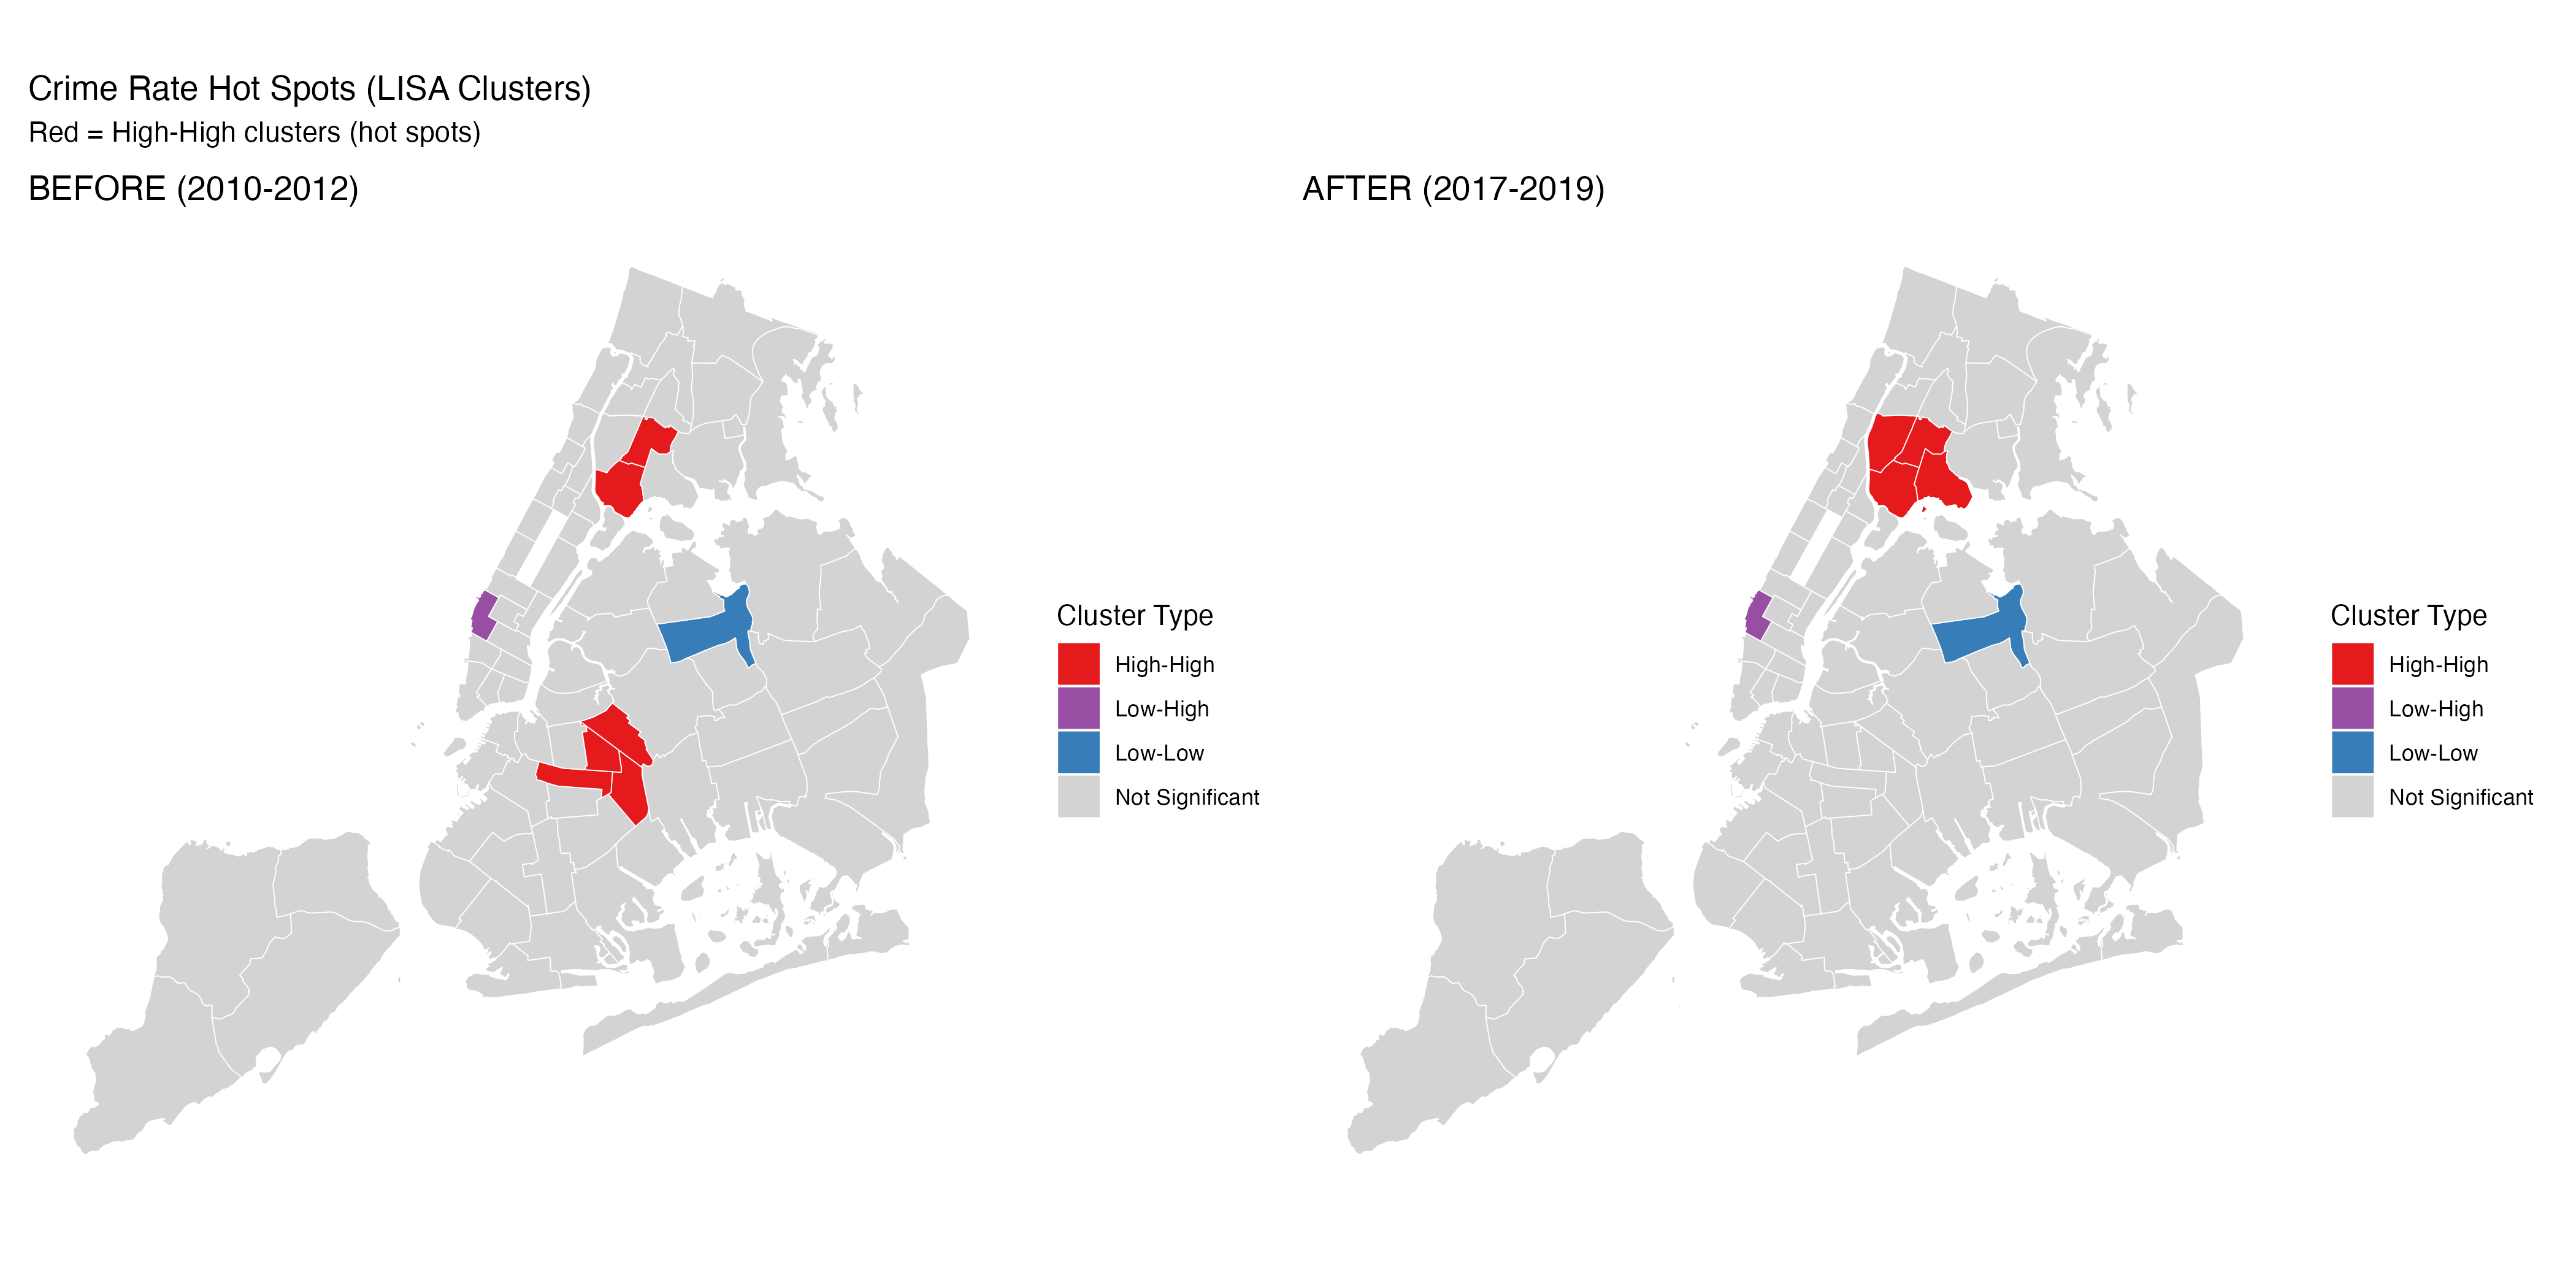
<figcaption aria-hidden="true">LISA cluster classifications for violent felony crime rates by precinct before (2010–2012) vs after (2013–2019) Patternizr.</figcaption>
</figure>

<figure>
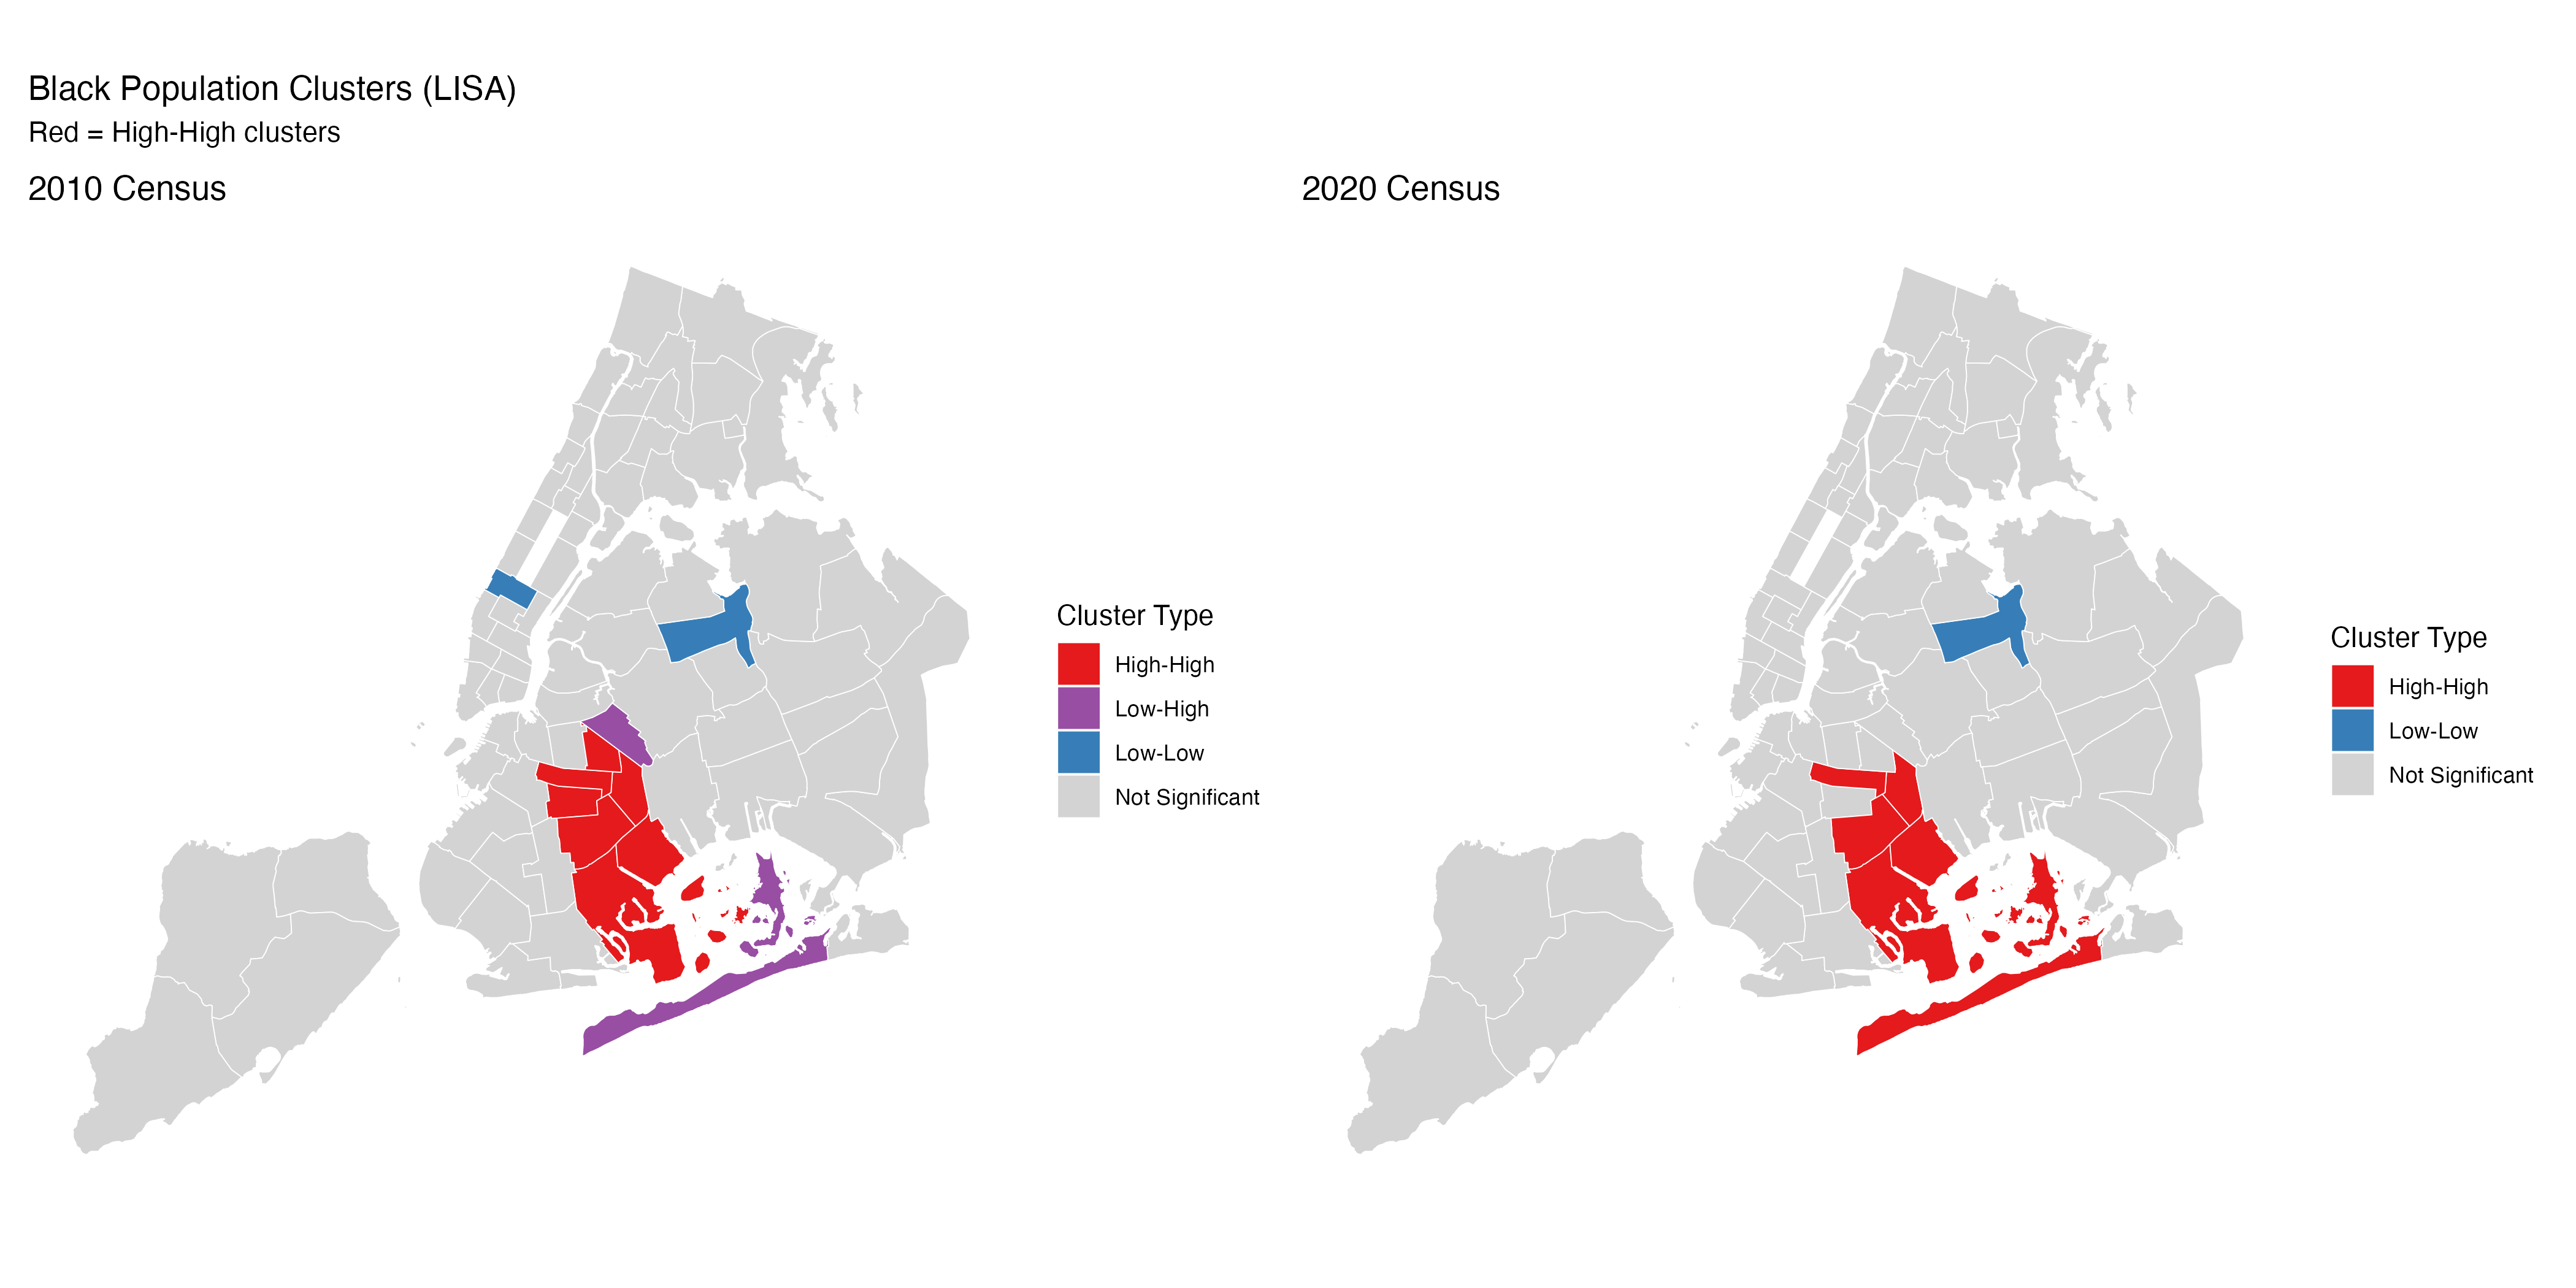
<figcaption aria-hidden="true">LISA cluster classifications for percent Black population by precinct (2010 Census vs 2020 Census).</figcaption>
</figure>

In the post-Patternizr period, this overlap fell to 0 precincts. Thus, while both crime and race remained spatially clustered in their own right, the geographic coincidence of Black-population hot spots with violent-crime hot spots disappeared in the post-implementation period.

### Monte Carlo evidence of “excess” clustering beyond population distribution

Monte Carlo simulations further indicate that the observed crime clustering is unlikely to be attributable to population distribution alone. Under a null model in which crimes are allocated proportionally to precinct population, the probability of observing crime-rate Moran’s I values as large as those measured is small in both periods (pre: $p = 0.003$; post: $p = 0.001$). These results imply that violent crime is significantly more spatially clustered than expected under population-proportional allocation, and that this “excess” clustering is at least as pronounced—if not more pronounced—in the post-Patternizr period.

<figure>
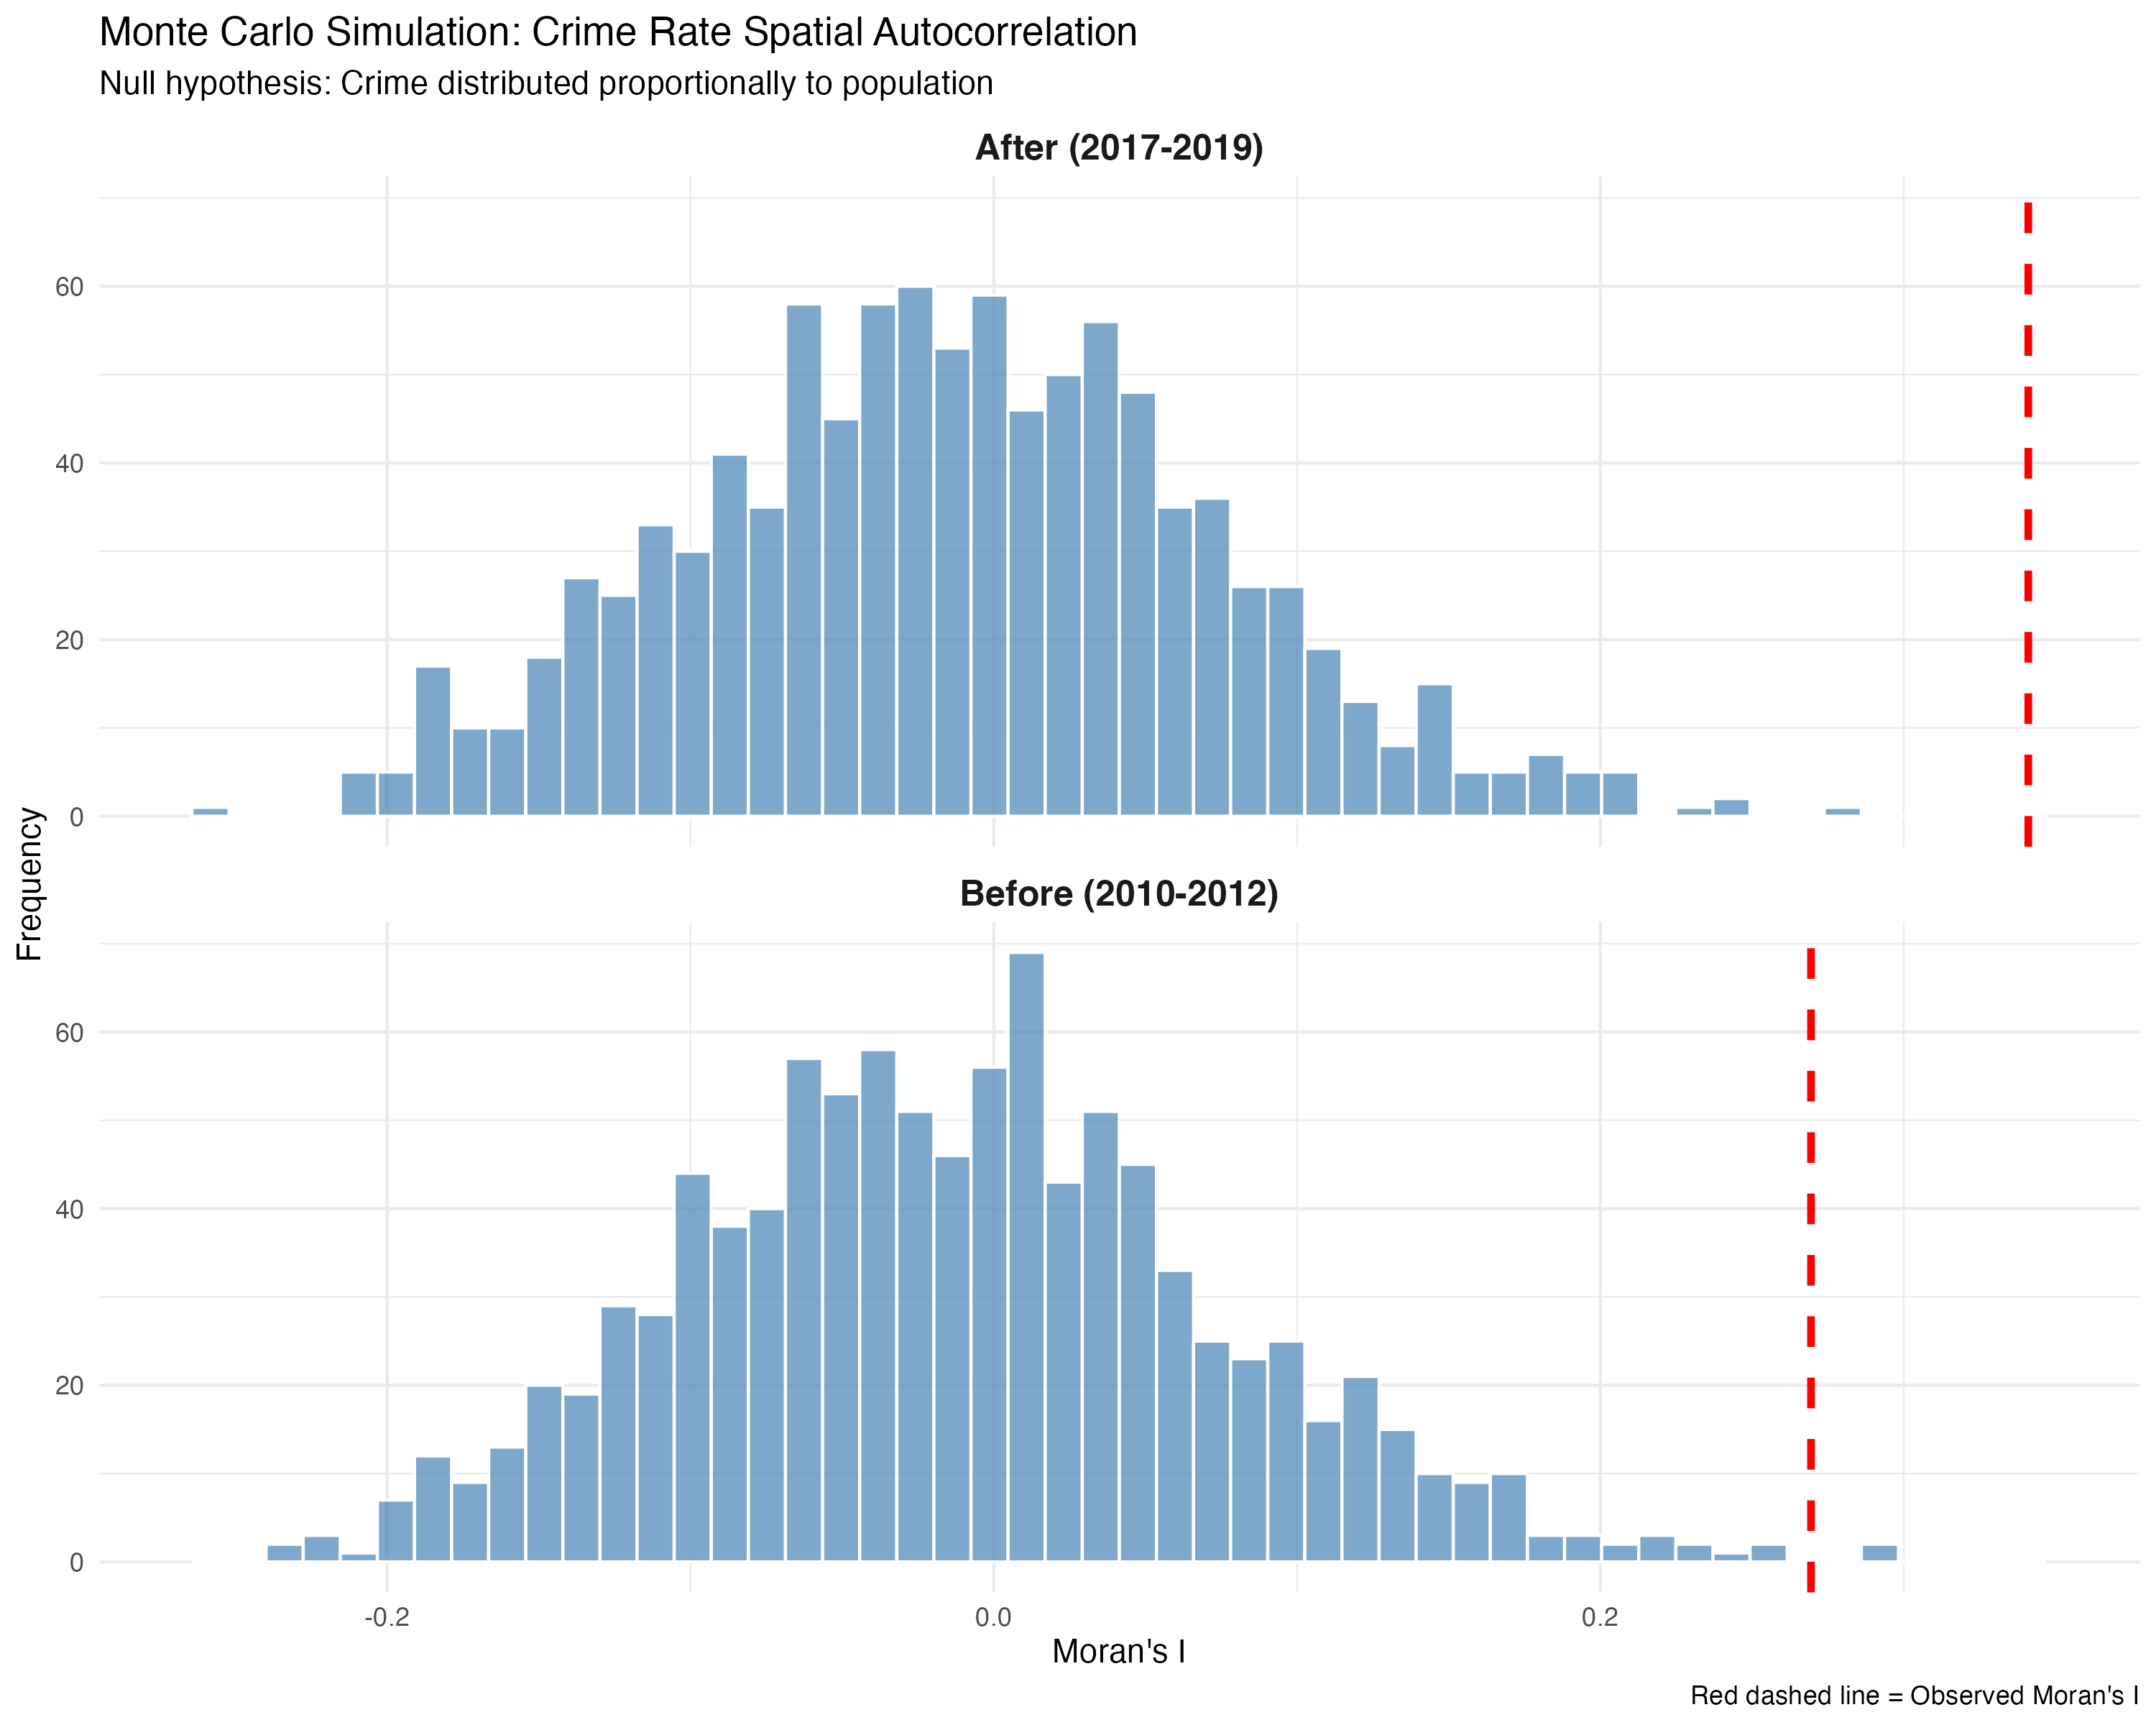
<figcaption aria-hidden="true">Monte Carlo null distributions of Moran’s I for crime rates under a population-proportional allocation model.</figcaption>
</figure>

### Geographically Weighted Regression

To assess spatial non-stationarity in the race–crime relationship, we fit geographically weighted regression (GWR) models in each period with precinct violent felony rate as the dependent variable and percent Black, percent Hispanic, and percent White as predictors. Across both periods, the GWR results indicate that the form of the demographic–crime relationship changes substantially after Patternizr, shifting from relatively smooth spatial variation to extreme localization and heterogeneity.

In the pre-Patternizr period (2010–2012), the optimal adaptive bandwidth selected by cross-validation was $q \approx 0.382$, corresponding to approximately 29 of 76 precincts contributing to each local estimate. This relatively large bandwidth implies that local coefficients are estimated using broad neighborhood information, producing a comparatively smooth spatial surface.

<figure>
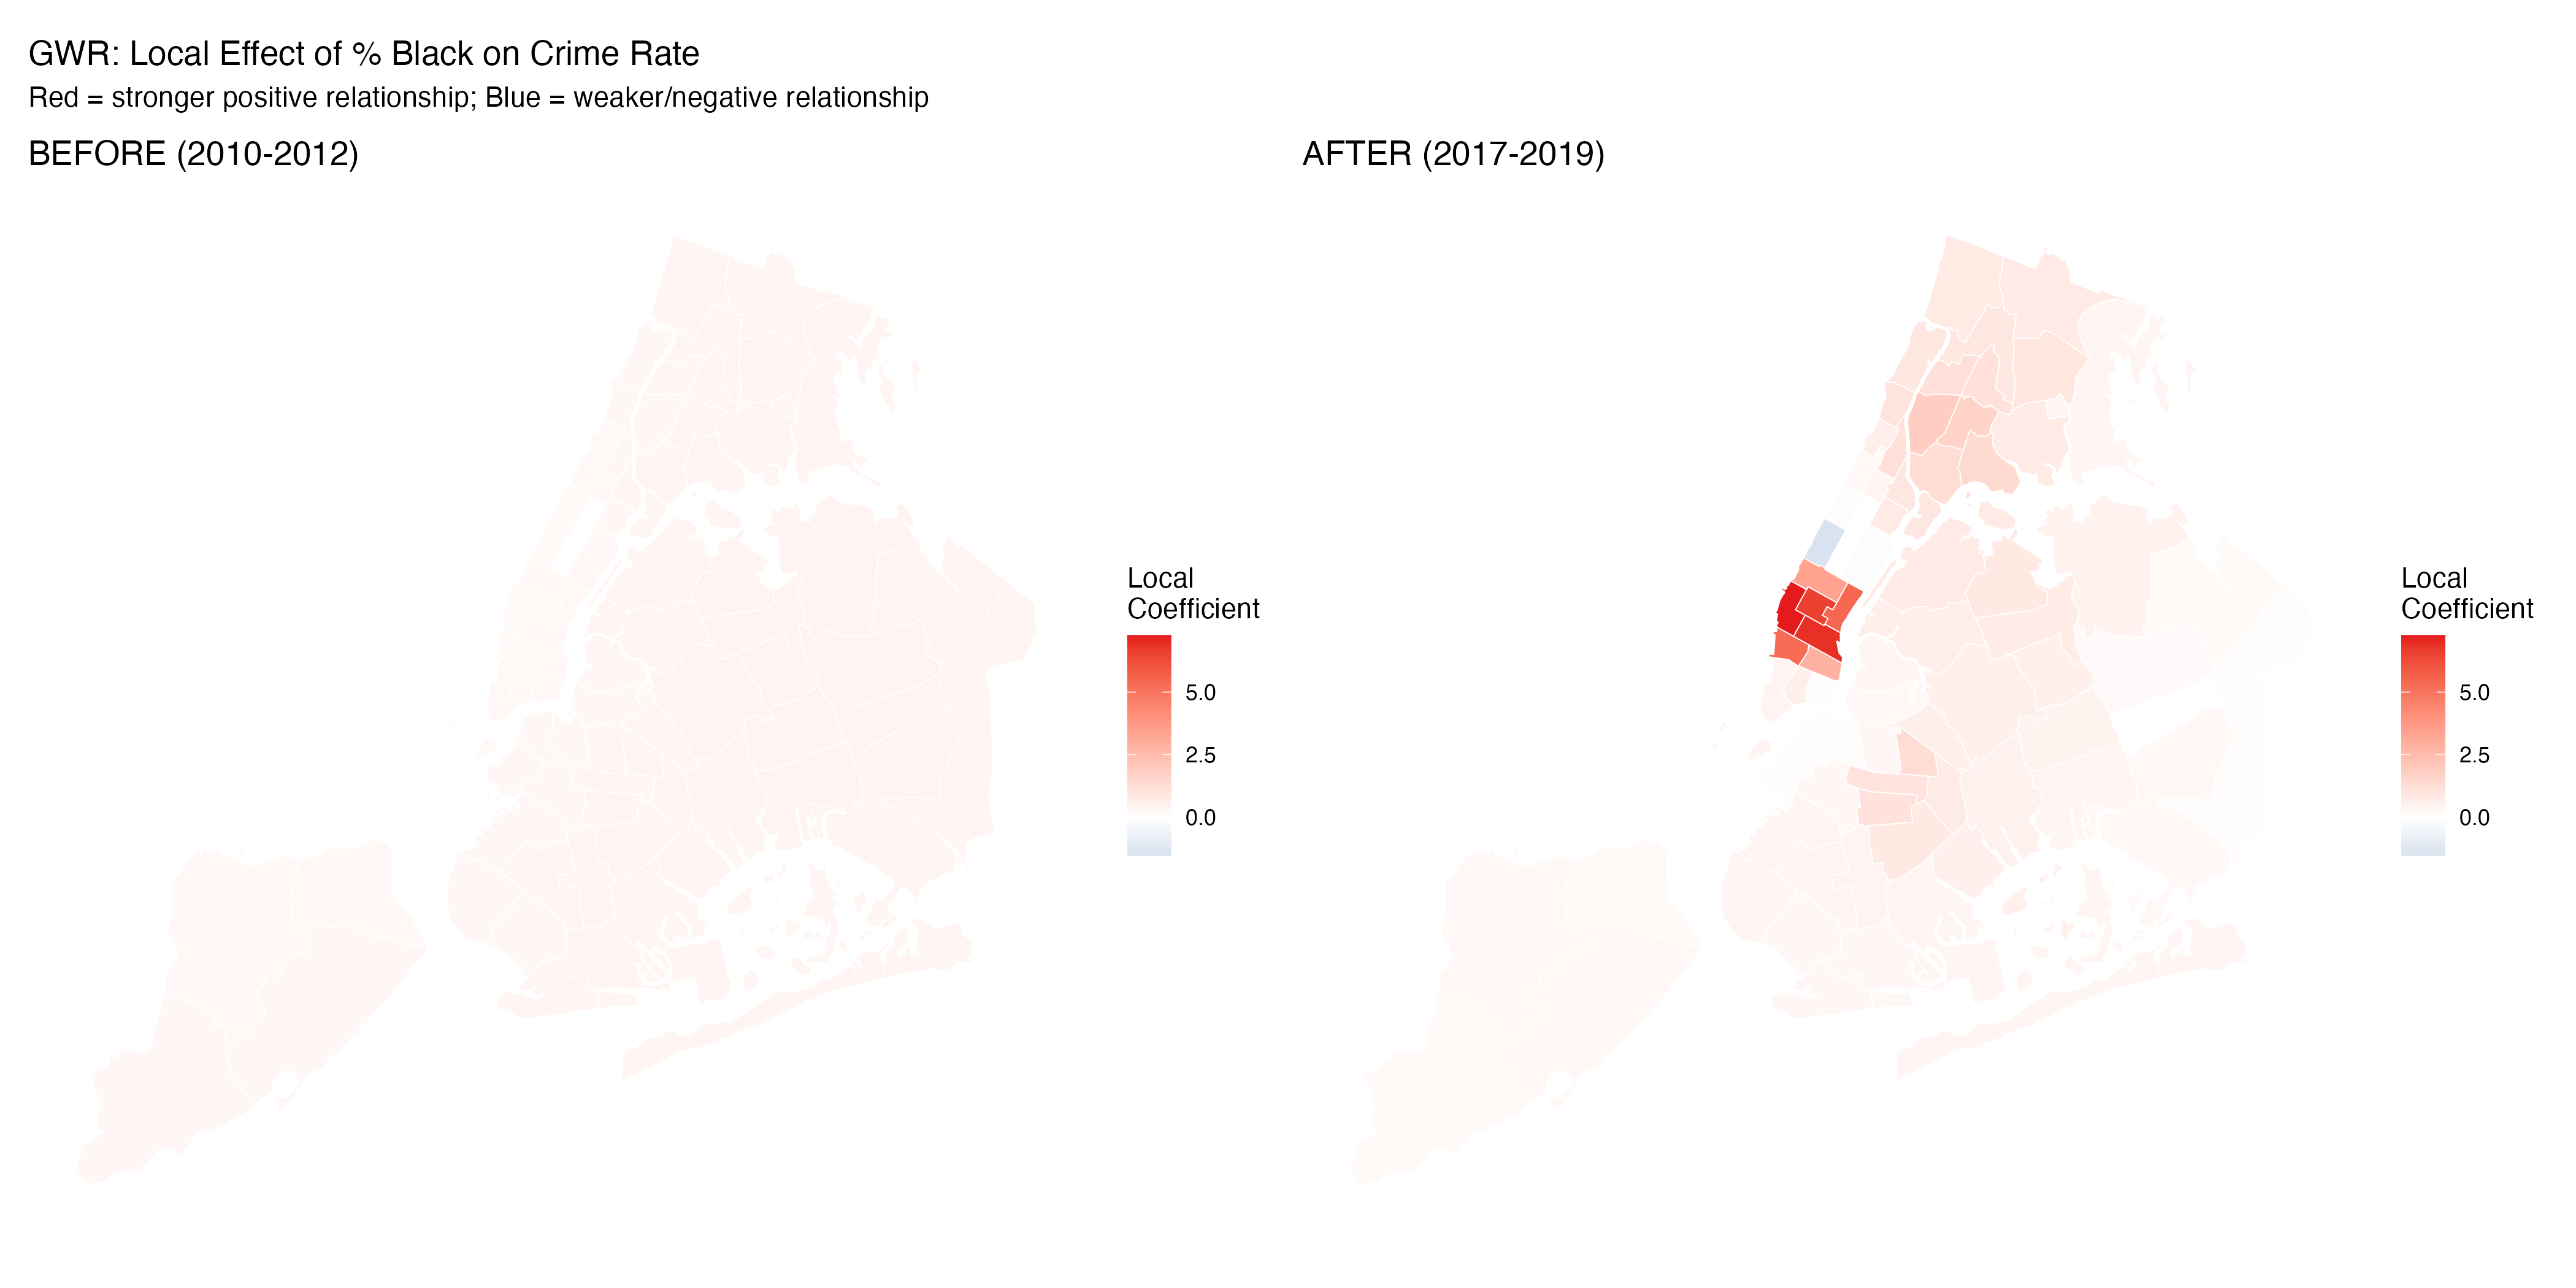
<figcaption aria-hidden="true">Geographically weighted regression (GWR) local coefficients for percent Black predicting violent felony crime rate.</figcaption>
</figure>

Consistent with this, the local %Black coefficient is uniformly positive and tightly distributed across precincts (min = 0.2328, median = 0.3176, max = 0.4034; mean = 0.3183). The quasi-global $R^2$ is 0.3585, indicating that allowing coefficients to vary spatially yields a moderate improvement in explanatory power relative to a purely global specification.

<figure>
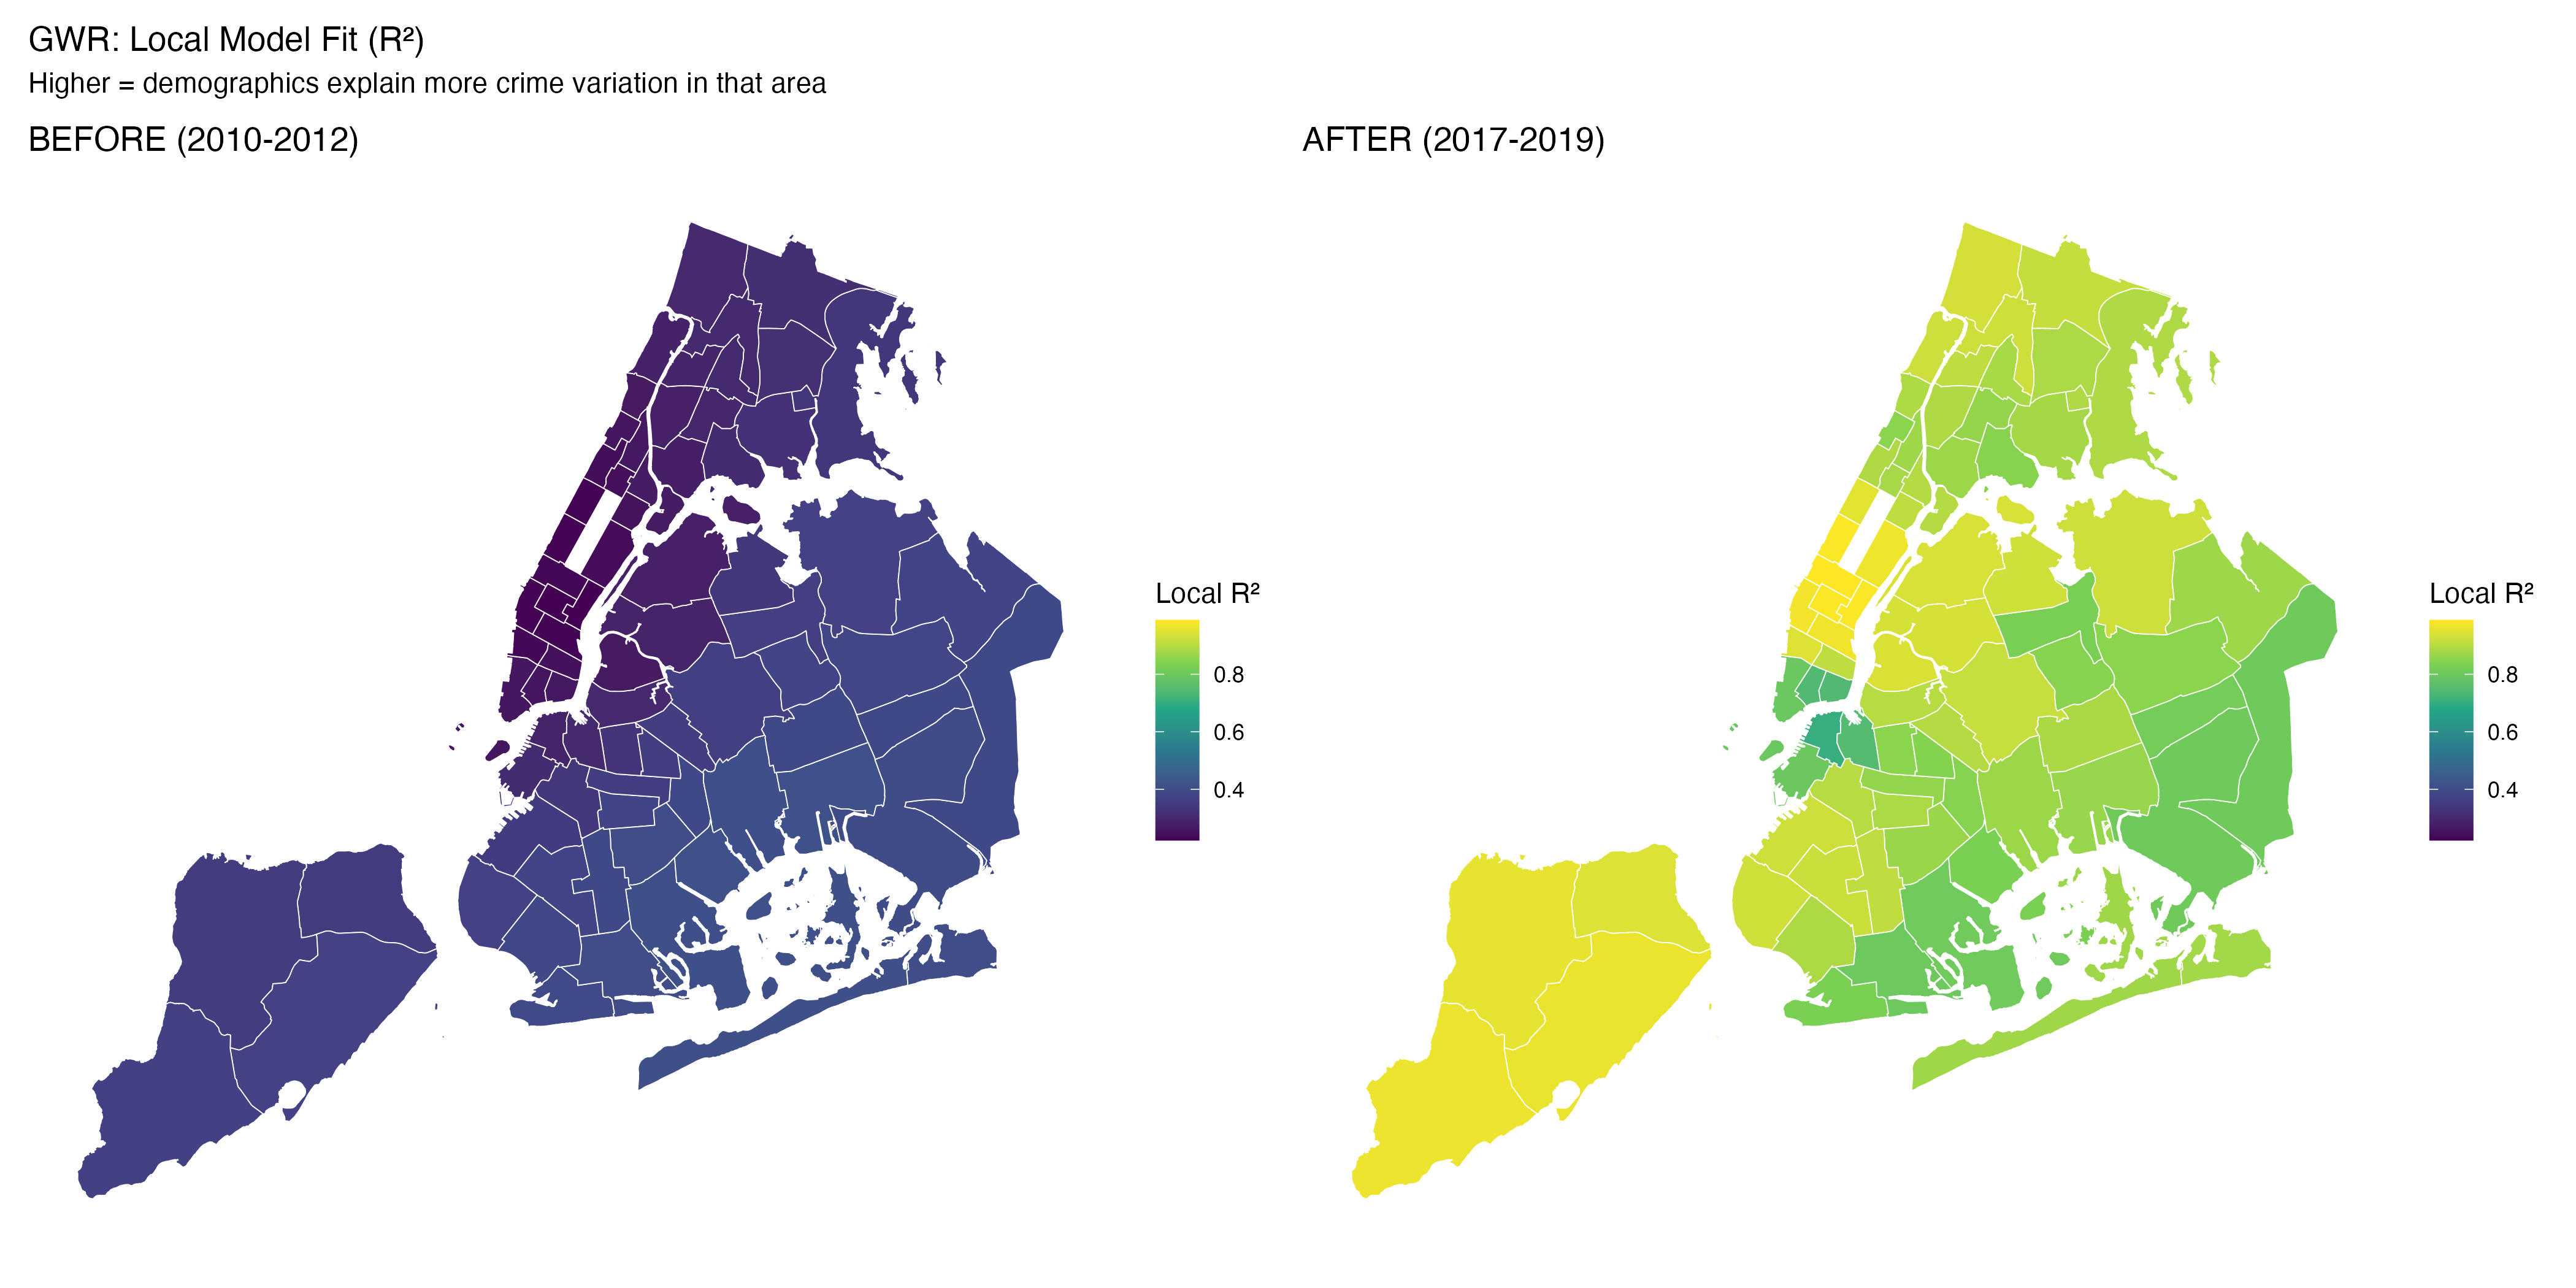
<figcaption aria-hidden="true">GWR local R² surfaces for 2010–2012 vs 2013–2019.</figcaption>
</figure>

In the post-Patternizr period (2013–2019), the optimal bandwidth shrinks dramatically to $q \approx 0.022$, corresponding to approximately 1 of 76 precincts contributing to each local estimate. This indicates an extremely localized specification and a strong departure from spatial stationarity. The distribution of local %Black coefficients expands sharply and changes qualitatively: coefficients range from negative to extremely large positive values (min = −3.7466, median = 1.2650, max = 18.1796; mean = 2.4041). The quasi-global $R^2$ rises to 0.9391, suggesting that the model—when permitted to vary at highly local scales—captures a very large share of precinct-level variation in crime rates.

However, the post-period GWR fit must be interpreted cautiously. The effective number of parameters increases markedly (approximately 39.2 in the post-period versus 6.7 in the pre-period), reflecting substantially greater model flexibility. As a result, the dramatic increase in quasi-global $R^2$ is consistent with heightened spatial heterogeneity but may also reflect overfitting induced by the extremely small adaptive bandwidth.

### Interpretation

Synthesizing the global, local, and GWR results yields a coherent descriptive pattern. First, violent crime becomes more spatially clustered after Patternizr (Moran’s I: 0.269 → 0.341), and this clustering is stronger than would be expected under a population-proportional null model in both periods (Monte Carlo $p = 0.003$ pre; $p = 0.001$ post). Second, racial composition remains highly clustered and changes little between periods ($I = 0.570$ pre; $I = 0.558$ post), indicating that segregation-like spatial structure persists regardless of policing regime. Third, despite these persistent forms of clustering, the spatial coincidence of Black-population hot spots and violent-crime hot spots disappears (overlap: 3 → 0 precincts).

The GWR results provide a plausible statistical complement to this spatial decoupling: before Patternizr, the association between %Black and crime rate is consistently positive and spatially smooth, whereas after Patternizr the relationship becomes sharply non-stationary, varying widely in magnitude and even sign across precincts. In practical terms, this implies that the post-Patternizr period is less well described by a single citywide race–crime gradient and more consistent with localized, place-specific dynamics. Importantly, this change is observational and does not, by itself, identify a causal effect of Patternizr. The post-period encompasses substantial social and demographic change, and the extreme localization implied by the selected bandwidth suggests that any causal interpretation would require additional identification strategies and sensitivity analyses.

## References

```` markdown
---
title: "Examining Claims of Racial Bias in Predictive Policing through a Geographic Perspective"
format:
  html:
    code-fold: true
    code-summary: "Show code"
authors:
  - name: Fareeza Ali and Jackson Howes
    affiliation: Georgetown University
    corresponding: true
bibliography: references.bib
execute:
  echo: true
  warning: false
  message: false
---

## Abstract

Predictive policing systems have been repeatedly criticized for reproducing and amplifying racial disparities, yet empirical evaluation is complicated by the fact that "crime data" are not neutral measurements of underlying criminal behavior but administrative records produced through enforcement, reporting, and institutional decision-making. In this manuscript, we assess whether spatial patterns in recorded violent felony incidents changed in ways consistent with the claim that algorithmic policing intensified racially disparate enforcement. We adopt a geographic perspective, using NYPD precincts as the unit of analysis, violent felony complaint records as the outcome, and census-derived racial composition as the principal demographic covariate. Our design compares a pre-period (2010–2012) and a post-period (2013–2019) bracketing the implementation window of Patternizr, a predictive policing system introduced by the NYPD in 2013. We quantify global spatial autocorrelation in both crime rates and Black population share using Moran's $I$, identify local clusters using Local Indicators of Spatial Association (LISA), and assess whether observed clustering exceeds what would be expected under a population-proportional null model via Monte Carlo simulation. Finally, we use geographically weighted regression (GWR) to examine whether the relationship between racial composition and recorded crime rates became more spatially heterogeneous over time. We emphasize throughout that any observed differences are associational rather than causal, given concurrent neighborhood change and other confounds; nonetheless, this framework isolates concrete spatial signatures that are directly relevant to claims of algorithmically mediated bias.

## Introduction

Public and scholarly debates over predictive policing have increasingly centered on a shared concern: that algorithmic systems trained on historically patterned enforcement data may re-entrench and intensify the very disparities they purport to mitigate. In the specific context of New York City, Patternizr has been described as a tool intended to assist in recognizing potentially related crime patterns; however, even systems framed as investigative aids may shape enforcement attention and thereby the geography of recorded crime. When police deploy resources unevenly across space, administrative "crime" data can reflect both underlying incidents and the spatial distribution of policing itself. As a result, testing claims of algorithmic bias requires methodological approaches that can separate (or at minimum, describe) changes in spatial concentration and demographic overlap.

We therefore pose a geographically grounded question: did the spatial structure of recorded violent felony crime become more clustered after the implementation of Patternizr, and did the geography of those clusters align differently with the geography of Black residential concentration? Importantly, our inferential target is not a direct causal estimate of Patternizr's effect. Instead, we evaluate whether the *spatial signatures* of recorded crime—global clustering, local hot spots, and hot-spot overlap with racially concentrated precincts—changed in ways that are consistent with common critiques of predictive policing. We explicitly treat demographic change, including gentrification and population redistribution between 2010 and 2020, as a major confound that must be described alongside any policing-related interpretation.

## Research Questions and Hypotheses

Our analysis is organized around three primary research questions.

1. **Did the spatial clustering of violent felony *crime rates* change between the pre-Patternizr and post-Patternizr periods?**
   If predictive policing concentrated enforcement attention into a narrower set of precincts, we would expect increased spatial autocorrelation in recorded crime rates. This motivates comparison of global Moran's $I$ for precinct-level crime rates across periods.

2. **Did the spatial clustering of Black residential concentration change over the same window, and how does it relate to crime clustering?**
   Racial residential segregation produces strong spatial autocorrelation in demographic composition. If this structure is stable while crime clustering changes, then changes in the *relationship* between demographic clustering and crime clustering become substantively interpretable.

3. **Did the overlap between crime hot spots and Black population hot spots change?**
   We operationalize "hot spot" using LISA High–High clusters. A reduction in overlap may indicate either (i) a weakening association between racial concentration and recorded crime hot spots, or (ii) demographic change in the precincts that previously occupied both categories.

In addition, we use geographically weighted regression (GWR) as a diagnostic to evaluate whether the local association between percent Black and precinct crime rates became more spatially heterogeneous over time. Substantively, a shift toward stronger spatial non-stationarity is consistent with a more localized policing geography, but this pattern can also arise from localized neighborhood change and other place-specific dynamics.

## Data and Study Design

### Setup and Load Libraries

quarto-executable-code-5450563D

```r
#| label: setup-libraries

library(tidyverse)
library(sf)
library(tidycensus)
library(tigris)
library(spdep)
library(patchwork)

options(tigris_use_cache = TRUE)
options(tigris_progress = FALSE)
```

### Spatial Units and Coordinate Systems

The unit of analysis is each NYPD precinct. We load an official precinct boundary shapefile and project it to an equal-area / planar coordinate system appropriate for spatial operations (EPSG:32118). All spatial overlays and neighborhood constructions (contiguity weights) are conducted in this projected CRS to ensure that area calculations and adjacency relationships are well-defined.

quarto-executable-code-5450563D

```r
#| label: load-precincts

precincts <- st_read("../data/nyc_precincts.geojson", quiet = TRUE)
precincts_proj <- st_transform(precincts, 32118)
```

### Demographic Data: Census Blocks to Precincts via Areal Interpolation

Because precinct boundaries do not align with census block boundaries, we construct precinct-level demographics using areal interpolation. Specifically, we obtain census block geometries and block-level decennial census counts for 2010 and 2020. For each census year, we intersect census blocks with precinct polygons, compute the proportion of each block's area contained within each precinct, and allocate block-level counts proportionally to those intersection weights. Summing the allocated counts across intersections yields precinct-level demographic totals.

Formally, let $b$ index census blocks and $p$ index precincts. Define the intersection area $A_{bp} = \text{area}(b \cap p)$ and block area $A_b = \text{area}(b)$. The areal weight is:

$$
w_{bp} = \frac{A_{bp}}{A_b}
$$

For a block-level count $X_b$ (e.g., total population, race counts), the precinct-allocated contribution from block $b$ is:

$$
X_{bp}^{\text{alloc}} = w_{bp} X_b
$$

and the precinct-level total is:

$$
X_p = \sum_{b} X_{bp}^{\text{alloc}}
$$

We then compute precinct demographic shares (e.g., percent Black) as:

$$
\%Black_p = 100 \times \frac{Black_p}{TotalPop_p}
$$

with analogous definitions for percent Hispanic and percent White.

This approach implicitly assumes uniform population density within each block. While imperfect, it is standard practice when translating census counts to non-nested administrative boundaries, and it produces internally consistent precinct-level denominators for per-capita crime rate computation.

#### 2020 Census Data Processing

quarto-executable-code-5450563D

```r
#| label: process-2020-census

# Load 2020 block geometries
blocks_2020 <- st_read("../data/tl_2020_36_tabblock20/tl_2020_36_tabblock20.shp", quiet = TRUE)

nyc_counties <- c("005", "047", "061", "081", "085")
blocks_2020_nyc <- blocks_2020 %>%
  filter(COUNTYFP20 %in% nyc_counties)

# Pull 2020 census data
p1_2020 <- get_decennial(
  geography = "block",
  variables = c("P1_001N", "P1_003N", "P1_004N", "P1_005N", 
                "P1_006N", "P1_007N", "P1_008N", "P1_009N"),
  state = "NY",
  county = nyc_counties,
  year = 2020,
  output = "wide"
)

p2_2020 <- get_decennial(
  geography = "block",
  variables = c("P2_001N", "P2_002N", "P2_003N"),
  state = "NY",
  county = nyc_counties,
  year = 2020,
  output = "wide"
)

# Join and interpolate 2020 data to precincts
p1_2020 <- p1_2020 %>% rename(GEOID20 = GEOID)
p2_2020 <- p2_2020 %>% rename(GEOID20 = GEOID)

blocks_demo_2020 <- blocks_2020_nyc %>%
  left_join(p1_2020, by = "GEOID20") %>%
  left_join(p2_2020, by = "GEOID20")

blocks_2020_proj <- st_transform(blocks_demo_2020, 32118)
blocks_2020_proj <- blocks_2020_proj %>%
  mutate(block_area = st_area(geometry))

block_precinct_int_2020 <- st_intersection(blocks_2020_proj, precincts_proj)
block_precinct_int_2020 <- block_precinct_int_2020 %>%
  mutate(
    piece_area = st_area(geometry),
    weight = as.numeric(piece_area / block_area)
  )

demo_vars_2020 <- c("P1_001N", "P1_003N", "P1_004N", "P1_005N",
                    "P1_006N", "P1_007N", "P1_008N", "P1_009N",
                    "P2_001N", "P2_002N", "P2_003N")

for (v in demo_vars_2020) {
  block_precinct_int_2020[[paste0(v, "_alloc")]] <-
    block_precinct_int_2020[[v]] * block_precinct_int_2020$weight
}

precinct_demographics_2020 <- block_precinct_int_2020 %>%
  st_drop_geometry() %>%
  group_by(precinct) %>%
  summarise(across(ends_with("_alloc"), sum, na.rm = TRUE))

precincts_2020 <- precincts_proj %>%
  left_join(precinct_demographics_2020, by = "precinct")
```

#### 2010 Census Data Processing

quarto-executable-code-5450563D

```r
#| label: process-2010-census

# Load 2010 block geometries
blocks_2010 <- blocks(state = "NY", county = nyc_counties, year = 2010)
blocks_2010_nyc <- blocks_2010 %>%
  filter(COUNTYFP10 %in% nyc_counties)

# Pull 2010 census data
p1_2010 <- get_decennial(
  geography = "block",
  variables = c("P003001", "P003002", "P003003", "P003004",
                "P003005", "P003006", "P003007", "P003008"),
  state = "NY",
  county = nyc_counties,
  year = 2010,
  output = "wide"
)

p2_2010 <- get_decennial(
  geography = "block",
  variables = c("P004001", "P004002", "P004003"),
  state = "NY",
  county = nyc_counties,
  year = 2010,
  output = "wide"
)

# Join and interpolate 2010 data to precincts
p1_2010 <- p1_2010 %>% rename(GEOID10 = GEOID)
p2_2010 <- p2_2010 %>% rename(GEOID10 = GEOID)

blocks_demo_2010 <- blocks_2010_nyc %>%
  left_join(p1_2010, by = "GEOID10") %>%
  left_join(p2_2010, by = "GEOID10")

blocks_2010_proj <- st_transform(blocks_demo_2010, 32118)
blocks_2010_proj <- blocks_2010_proj %>%
  mutate(block_area = st_area(geometry))

block_precinct_int_2010 <- st_intersection(blocks_2010_proj, precincts_proj)
block_precinct_int_2010 <- block_precinct_int_2010 %>%
  mutate(
    piece_area = st_area(geometry),
    weight = as.numeric(piece_area / block_area)
  )

demo_vars_2010 <- c("P003001", "P003002", "P003003", "P003004",
                    "P003005", "P003006", "P003007", "P003008",
                    "P004001", "P004002", "P004003")

for (v in demo_vars_2010) {
  block_precinct_int_2010[[paste0(v, "_alloc")]] <-
    block_precinct_int_2010[[v]] * block_precinct_int_2010$weight
}

precinct_demographics_2010 <- block_precinct_int_2010 %>%
  st_drop_geometry() %>%
  group_by(precinct) %>%
  summarise(across(ends_with("_alloc"), sum, na.rm = TRUE))

precincts_2010 <- precincts_proj %>%
  left_join(precinct_demographics_2010, by = "precinct")
```

#### Standardize Column Names

quarto-executable-code-5450563D

```r
#| label: standardize-columns

precincts_2010 <- precincts_2010 %>%
  rename(
    total_pop_alloc = P003001_alloc,
    white_alloc = P003002_alloc,
    black_alloc = P003003_alloc,
    aian_alloc = P003004_alloc,
    asian_alloc = P003005_alloc,
    nhpi_alloc = P003006_alloc,
    other_alloc = P003007_alloc,
    two_or_more_alloc = P003008_alloc,
    hispanic_total_alloc = P004001_alloc,
    hispanic_alloc = P004002_alloc,
    not_hispanic_alloc = P004003_alloc
  )

precincts_2020 <- precincts_2020 %>%
  rename(
    total_pop_alloc = P1_001N_alloc,
    white_alloc = P1_003N_alloc,
    black_alloc = P1_004N_alloc,
    aian_alloc = P1_005N_alloc,
    asian_alloc = P1_006N_alloc,
    nhpi_alloc = P1_007N_alloc,
    other_alloc = P1_008N_alloc,
    two_or_more_alloc = P1_009N_alloc,
    hispanic_total_alloc = P2_001N_alloc,
    hispanic_alloc = P2_002N_alloc,
    not_hispanic_alloc = P2_003N_alloc
  )
```

### Crime Data: Violent Felony Complaint Records

We load a cleaned violent felony complaint dataset from the city containing point locations (latitude/longitude) and complaint dates. Complaint points are converted into an `sf` point object in WGS84 (EPSG:4326) and then filtered to a bounding box corresponding to New York City to remove obvious geocoding errors. Points are subsequently projected into EPSG:32118 for spatial joins and distance-consistent operations. Complaint dates are parsed to extract year, enabling period-based subsetting.

quarto-executable-code-5450563D

```r
#| label: load-crime-data

violent_crimes <- read.csv("../data/violent_felony_cleaned_13.csv")

violent_sf <- st_as_sf(
  violent_crimes,
  coords = c("long", "lat"),
  crs = 4326
)

violent_sf <- violent_sf %>%
  filter(
    !is.na(geometry),
    sf::st_coordinates(geometry)[, 1] > -74.5,
    sf::st_coordinates(geometry)[, 1] < -73.7,
    sf::st_coordinates(geometry)[, 2] > 40.45,
    sf::st_coordinates(geometry)[, 2] < 40.95
  )

violent_proj <- st_transform(violent_sf, 32118)

violent_proj <- violent_proj %>%
  mutate(
    complaint_date = as.Date(complaint_date),
    year = as.integer(format(complaint_date, "%Y"))
  )
```

### Pre/Post Comparison Windows

To reduce transitional ambiguity surrounding the implementation timeline, we define two non-overlapping windows:

- **Before**: 2010–2012
- **After**: 2013–2019

For each period, we spatially join complaint points to precinct polygons, count incidents per precinct, and compute the precinct-level violent felony rate per 1,000 residents:

$$
CrimeRate_p = 1000 \times \frac{Crimes_p}{TotalPop_p}
$$

We exclude precinct 22 (Central Park) due to its negligible residential population, which otherwise induces artificially inflated per-capita rates and undermines interpretability.

quarto-executable-code-5450563D

```r
#| label: create-before-after-datasets

# Filter crimes by period
crimes_before <- violent_proj %>% filter(year >= 2010 & year <= 2012)
crimes_after <- violent_proj %>% filter(year >= 2013 & year <= 2019)

cat("Crimes before (2010-2012):", nrow(crimes_before), "\n")
cat("Crimes after (2013-2019):", nrow(crimes_after), "\n")

# Count crimes per precinct - BEFORE
crime_counts_before <- crimes_before %>%
  st_join(precincts_proj, join = st_within) %>%
  st_drop_geometry() %>%
  group_by(precinct) %>%
  summarise(total_crimes = n(), .groups = "drop")

precincts_before <- precincts_2010 %>%
  left_join(crime_counts_before, by = "precinct") %>%
  mutate(
    total_crimes = replace_na(total_crimes, 0),
    crime_rate = (total_crimes / total_pop_alloc) * 1000,
    pct_black = (black_alloc / total_pop_alloc) * 100,
    pct_hispanic = (hispanic_alloc / total_pop_alloc) * 100,
    pct_white = (white_alloc / total_pop_alloc) * 100
  )

# Count crimes per precinct - AFTER
crime_counts_after <- crimes_after %>%
  st_join(precincts_proj, join = st_within) %>%
  st_drop_geometry() %>%
  group_by(precinct) %>%
  summarise(total_crimes = n(), .groups = "drop")

precincts_after <- precincts_2020 %>%
  left_join(crime_counts_after, by = "precinct") %>%
  mutate(
    total_crimes = replace_na(total_crimes, 0),
    crime_rate = (total_crimes / total_pop_alloc) * 1000,
    pct_black = (black_alloc / total_pop_alloc) * 100,
    pct_hispanic = (hispanic_alloc / total_pop_alloc) * 100,
    pct_white = (white_alloc / total_pop_alloc) * 100
  )

# Remove Central Park (Precinct 22) - negligible residential population
precincts_before <- precincts_before %>% filter(precinct != "22")
precincts_after <- precincts_after %>% filter(precinct != "22")

cat("Precincts remaining (before):", nrow(precincts_before), "\n")
cat("Precincts remaining (after):", nrow(precincts_after), "\n")
```

quarto-executable-code-5450563D

```r
#| label: summary-stats

cat("=== BEFORE (excluding Central Park) ===\n")
summary(precincts_before$crime_rate)

cat("\n=== AFTER (excluding Central Park) ===\n")
summary(precincts_after$crime_rate)
```

## Methods Overview

Our empirical strategy combines (i) global measures of spatial autocorrelation, (ii) local cluster detection, (iii) a simulation-based null model to benchmark observed clustering, and (iv) a spatially varying regression diagnostic. These components correspond directly to the computational workflow implemented below.

### Global Spatial Autocorrelation: Moran's I

We quantify global spatial autocorrelation using Moran's $I$ for two variables: (a) precinct crime rates and (b) percent Black population. Spatial dependence is defined using a queen contiguity neighborhood structure (shared edges or corners). Let $x_p$ denote a precinct-level variable (e.g., crime rate) and $\bar{x}$ its mean. With spatial weights $w_{pq}$ (row-standardized), Moran's $I$ is:

$$
I = \frac{n}{S_0}\frac{\sum_{p}\sum_{q} w_{pq}(x_p - \bar{x})(x_q - \bar{x})}{\sum_{p}(x_p - \bar{x})^2}
$$

where $n$ is the number of precincts and $S_0 = \sum_{p}\sum_{q} w_{pq}$. We compute Moran's $I$ separately for each period and interpret differences as changes in the degree of clustering in the precinct-level surfaces.

quarto-executable-code-5450563D

```r
#| label: create-spatial-weights

# Convert to sp objects for spdep
precincts_before_sp <- as(precincts_before, "Spatial")
precincts_after_sp <- as(precincts_after, "Spatial")

# Create queen contiguity neighbors (precincts sharing edges or corners)
nb_before <- poly2nb(precincts_before_sp, queen = TRUE)
nb_after <- poly2nb(precincts_after_sp, queen = TRUE)

# Convert to spatial weights (row-standardized)
weights_before <- nb2listw(nb_before, style = "W", zero.policy = TRUE)
weights_after <- nb2listw(nb_after, style = "W", zero.policy = TRUE)

cat("Spatial weights created successfully\n")
cat("Average # of neighbors (before):", round(mean(card(nb_before)), 2), "\n")
cat("Average # of neighbors (after):", round(mean(card(nb_after)), 2), "\n")
```

quarto-executable-code-5450563D

```r
#| label: morans-i-crime-rate

cat("========== GLOBAL MORAN'S I: CRIME RATE ==========\n\n")

# Before period
moran_crime_before <- moran.test(precincts_before$crime_rate, weights_before)
cat("--- BEFORE (2010-2012) ---\n")
print(moran_crime_before)

# After period
moran_crime_after <- moran.test(precincts_after$crime_rate, weights_after)
cat("\n--- AFTER (2013-2019) ---\n")
print(moran_crime_after)
```

quarto-executable-code-5450563D

```r
#| label: morans-i-pct-black

cat("========== GLOBAL MORAN'S I: PCT BLACK ==========\n\n")

# Before period
moran_black_before <- moran.test(precincts_before$pct_black, weights_before)
cat("--- BEFORE (2010-2012) ---\n")
print(moran_black_before)

# After period
moran_black_after <- moran.test(precincts_after$pct_black, weights_after)
cat("\n--- AFTER (2013-2019) ---\n")
print(moran_black_after)
```

quarto-executable-code-5450563D

```r
#| label: morans-summary-table

moran_summary <- data.frame(
  Variable = c("Crime Rate", "Crime Rate", "Pct Black", "Pct Black"),
  Period = c("Before", "After", "Before", "After"),
  Morans_I = c(
    moran_crime_before$estimate["Moran I statistic"],
    moran_crime_after$estimate["Moran I statistic"],
    moran_black_before$estimate["Moran I statistic"],
    moran_black_after$estimate["Moran I statistic"]
  ),
  P_Value = c(
    moran_crime_before$p.value,
    moran_crime_after$p.value,
    moran_black_before$p.value,
    moran_black_after$p.value
  )
)

cat("========== MORAN'S I SUMMARY ==========\n")
print(moran_summary)
```

### Local Moran's I and LISA Cluster Typology

To identify localized clusters and spatial outliers, we compute Local Moran's $I$ (LISA) for both crime rates and percent Black. We classify each precinct into one of five categories based on the sign of its standardized value and the sign of its spatial lag (neighbors' average), conditional on statistical significance:

- High–High (hot spot): high value surrounded by high values
- Low–Low (cold spot): low value surrounded by low values
- High–Low: high outlier surrounded by low values
- Low–High: low outlier surrounded by high values
- Not significant

The key substantive comparison is whether High–High crime precincts co-occur with High–High Black precincts, and whether the count (and identity) of overlapping precincts changes from the pre-period to the post-period.

quarto-executable-code-5450563D

```r
#| label: lisa-analysis

# Compute Local Moran's I
lisa_crime_before <- localmoran(precincts_before$crime_rate, weights_before)
lisa_black_before <- localmoran(precincts_before$pct_black, weights_before)
lisa_crime_after <- localmoran(precincts_after$crime_rate, weights_after)
lisa_black_after <- localmoran(precincts_after$pct_black, weights_after)

# Function to classify LISA clusters
get_lisa_clusters <- function(variable, lisa_output, weights) {
  z <- scale(variable)[,1]
  lag_z <- lag.listw(weights, z)
  p_value <- lisa_output[, 5]
  
  cluster <- case_when(
    p_value > 0.05 ~ "Not Significant",
    z > 0 & lag_z > 0 ~ "High-High",
    z < 0 & lag_z < 0 ~ "Low-Low",
    z > 0 & lag_z < 0 ~ "High-Low",
    z < 0 & lag_z > 0 ~ "Low-High",
    TRUE ~ "Not Significant"
  )
  
  return(cluster)
}

# Apply to all four combinations
precincts_before$lisa_crime <- get_lisa_clusters(
  precincts_before$crime_rate, lisa_crime_before, weights_before
)
precincts_before$lisa_black <- get_lisa_clusters(
  precincts_before$pct_black, lisa_black_before, weights_before
)
precincts_after$lisa_crime <- get_lisa_clusters(
  precincts_after$crime_rate, lisa_crime_after, weights_after
)
precincts_after$lisa_black <- get_lisa_clusters(
  precincts_after$pct_black, lisa_black_after, weights_after
)
```

quarto-executable-code-5450563D

```r
#| label: lisa-summary

cat("=== LISA Clusters: CRIME RATE ===\n")
cat("BEFORE:\n")
print(table(precincts_before$lisa_crime))
cat("\nAFTER:\n")
print(table(precincts_after$lisa_crime))

cat("\n=== LISA Clusters: PCT BLACK ===\n")
cat("BEFORE:\n")
print(table(precincts_before$lisa_black))
cat("\nAFTER:\n")
print(table(precincts_after$lisa_black))
```

quarto-executable-code-5450563D

```r
#| label: lisa-overlap

cat("=== OVERLAP: High-High Crime AND High-High Black ===\n\n")

# Before period
overlap_before <- precincts_before %>%
  st_drop_geometry() %>%
  filter(lisa_crime == "High-High" & lisa_black == "High-High") %>%
  select(precinct, crime_rate, pct_black)

cat("BEFORE - Precincts that are High-High for BOTH crime and Black population:\n")
print(overlap_before)
cat("Count:", nrow(overlap_before), "\n\n")

# After period
overlap_after <- precincts_after %>%
  st_drop_geometry() %>%
  filter(lisa_crime == "High-High" & lisa_black == "High-High") %>%
  select(precinct, crime_rate, pct_black)

cat("AFTER - Precincts that are High-High for BOTH crime and Black population:\n")
print(overlap_after)
cat("Count:", nrow(overlap_after), "\n")
```

quarto-executable-code-5450563D

```r
#| label: lisa-crosstab

cat("=== Full Cross-Tabulation: Crime Clusters vs Black Clusters ===\n\n")
cat("BEFORE:\n")
print(table(precincts_before$lisa_crime, precincts_before$lisa_black))

cat("\nAFTER:\n")
print(table(precincts_after$lisa_crime, precincts_after$lisa_black))
```

quarto-executable-code-5450563D

```r
#| label: track-precincts

track_precincts <- c("73", "77", "81")

cat("=== Tracking Precincts 73, 77, 81 ===\n\n")

cat("BEFORE (2010-2012):\n")
precincts_before %>%
  st_drop_geometry() %>%
  filter(precinct %in% track_precincts) %>%
  select(precinct, total_crimes, crime_rate, pct_black, lisa_crime, lisa_black) %>%
  print()

cat("\nAFTER (2013-2019):\n")
precincts_after %>%
  st_drop_geometry() %>%
  filter(precinct %in% track_precincts) %>%
  select(precinct, total_crimes, crime_rate, pct_black, lisa_crime, lisa_black) %>%
  print()

cat("\n=== Which precincts are High-High for crime AFTER? ===\n")
precincts_after %>%
  st_drop_geometry() %>%
  filter(lisa_crime == "High-High") %>%
  select(precinct, crime_rate, pct_black, lisa_black) %>%
  print()

cat("\n=== Which precincts are High-High for Black pop AFTER? ===\n")
precincts_after %>%
  st_drop_geometry() %>%
  filter(lisa_black == "High-High") %>%
  select(precinct, crime_rate, pct_black, lisa_crime) %>%
  print()
```

### Monte Carlo Null Model for Crime Clustering

Global Moran's $I$ can be statistically significant even under modest clustering when sample sizes are large; more importantly, observed clustering may reflect population distribution rather than any additional geographic process. We therefore implement a Monte Carlo simulation under a population-proportional null:

- The total number of crimes observed in a period is held fixed.
- Crimes are randomly allocated to precincts with probability proportional to precinct population.
- Simulated crime rates are computed and Moran's $I$ is evaluated for each simulation.

Let $C$ be the observed number of crimes in a period and $p_p = \frac{Pop_p}{\sum_q Pop_q}$. A single simulation draws precinct crime counts:

$$
(C_1,\ldots,C_n) \sim \text{Multinomial}\left(C; p_1,\ldots,p_n\right)
$$

and constructs simulated rates $CrimeRate_p^{(s)} = 1000 \times \frac{C_p}{Pop_p}$. Repeating this process yields an empirical null distribution of Moran's $I$. We compute the Monte Carlo p-value as the proportion of simulated Moran's $I$ values greater than or equal to the observed $I$ (with a standard +1 correction):

$$
p = \frac{\#\{I^{(s)} \ge I^{obs}\} + 1}{S + 1}
$$

where $S$ is the number of simulations.

quarto-executable-code-5450563D

```r
#| label: monte-carlo-function

set.seed(65)

simulate_morans_i <- function(precincts_df, weights, n_sims = 999) {
  total_crimes <- sum(precincts_df$total_crimes)
  populations <- precincts_df$total_pop_alloc
  total_pop <- sum(populations)
  pop_proportions <- populations / total_pop
  sim_morans <- numeric(n_sims)
  
  for (i in 1:n_sims) {
    sim_crimes <- rmultinom(1, size = total_crimes, prob = pop_proportions)[,1]
    sim_rate <- (sim_crimes / populations) * 1000
    sim_rate[is.infinite(sim_rate)] <- 0
    sim_moran <- moran(sim_rate, weights, n = length(sim_rate), S0 = Szero(weights))
    sim_morans[i] <- sim_moran$I
    
    if (i %% 100 == 0) {
      cat("Completed", i, "of", n_sims, "simulations\n")
    }
  }
  
  return(sim_morans)
}
```

quarto-executable-code-5450563D

```r
#| label: monte-carlo-before

cat("\n========== BEFORE PERIOD SIMULATION ==========\n")

observed_moran_before <- moran(
  precincts_before$crime_rate, 
  weights_before, 
  n = nrow(precincts_before), 
  S0 = Szero(weights_before)
)$I

cat("Observed Moran's I (Before):", round(observed_moran_before, 4), "\n\n")

cat("Running 999 simulations under null hypothesis...\n")
sim_morans_before <- simulate_morans_i(precincts_before, weights_before, n_sims = 999)

p_value_before <- (sum(sim_morans_before >= observed_moran_before) + 1) / (999 + 1)

cat("\nSimulation Results (Before):\n")
cat("  Mean simulated Moran's I:", round(mean(sim_morans_before), 4), "\n")
cat("  SD simulated Moran's I:", round(sd(sim_morans_before), 4), "\n")
cat("  Observed Moran's I:", round(observed_moran_before, 4), "\n")
cat("  Monte Carlo p-value:", round(p_value_before, 4), "\n")
```

quarto-executable-code-5450563D

```r
#| label: monte-carlo-after

cat("\n========== AFTER PERIOD SIMULATION ==========\n")

observed_moran_after <- moran(
  precincts_after$crime_rate, 
  weights_after, 
  n = nrow(precincts_after), 
  S0 = Szero(weights_after)
)$I

cat("Observed Moran's I (After):", round(observed_moran_after, 4), "\n\n")

cat("Running 999 simulations under null hypothesis...\n")
sim_morans_after <- simulate_morans_i(precincts_after, weights_after, n_sims = 999)

p_value_after <- (sum(sim_morans_after >= observed_moran_after) + 1) / (999 + 1)

cat("\nSimulation Results (After):\n")
cat("  Mean simulated Moran's I:", round(mean(sim_morans_after), 4), "\n")
cat("  SD simulated Moran's I:", round(sd(sim_morans_after), 4), "\n")
cat("  Observed Moran's I:", round(observed_moran_after, 4), "\n")
cat("  Monte Carlo p-value:", round(p_value_after, 4), "\n")
```

quarto-executable-code-5450563D

```r
#| label: monte-carlo-plot

sim_df <- data.frame(
  Morans_I = c(sim_morans_before, sim_morans_after),
  Period = rep(c("Before (2010-2012)", "After (2013-2019)"), each = 999)
)

observed_df <- data.frame(
  Morans_I = c(observed_moran_before, observed_moran_after),
  Period = c("Before (2010-2012)", "After (2013-2019)")
)

monte_carlo_plot <- ggplot(sim_df, aes(x = Morans_I)) +
  geom_histogram(bins = 50, fill = "steelblue", alpha = 0.7, color = "white") +
  geom_vline(data = observed_df, aes(xintercept = Morans_I), 
             color = "red", linetype = "dashed", linewidth = 1.2) +
  facet_wrap(~Period, ncol = 1) +
  theme_minimal() +
  labs(
    title = "Monte Carlo Simulation: Crime Rate Spatial Autocorrelation",
    subtitle = "Null hypothesis: Crime distributed proportionally to population",
    x = "Moran's I",
    y = "Frequency",
    caption = "Red dashed line = Observed Moran's I"
  ) +
  theme(strip.text = element_text(size = 12, face = "bold"))

print(monte_carlo_plot)
```

quarto-executable-code-5450563D

```r
#| label: monte-carlo-summary

mc_summary <- data.frame(
  Period = c("Before (2010-2012)", "After (2013-2019)"),
  Observed_Morans_I = c(observed_moran_before, observed_moran_after),
  Mean_Simulated = c(mean(sim_morans_before), mean(sim_morans_after)),
  SD_Simulated = c(sd(sim_morans_before), sd(sim_morans_after)),
  P_Value = c(p_value_before, p_value_after)
)

cat("========== MONTE CARLO SUMMARY ==========\n")
print(mc_summary)

cat("\n========== INTERPRETATION ==========\n")
if (p_value_before < 0.05) {
  cat("BEFORE: Reject null hypothesis - crime is MORE clustered than expected under population-proportional distribution (p =", round(p_value_before, 4), ")\n")
} else {
  cat("BEFORE: Fail to reject null - crime clustering is consistent with population-proportional distribution (p =", round(p_value_before, 4), ")\n")
}

if (p_value_after < 0.05) {
  cat("AFTER: Reject null hypothesis - crime is MORE clustered than expected under population-proportional distribution (p =", round(p_value_after, 4), ")\n")
} else {
  cat("AFTER: Fail to reject null - crime clustering is consistent with population-proportional distribution (p =", round(p_value_after, 4), ")\n")
}
```

### Geographically Weighted Regression

Finally, we fit geographically weighted regression (GWR) models in each period to assess spatial non-stationarity in the association between racial composition and crime rates. For precinct $p$ with coordinates $(u_p, v_p)$, GWR estimates location-specific coefficients:

$$
CrimeRate_p = \beta_0(u_p,v_p) + \beta_1(u_p,v_p)\%Black_p + \beta_2(u_p,v_p)\%Hispanic_p + \beta_3(u_p,v_p)\%White_p + \varepsilon_p
$$

An adaptive bandwidth is selected via the standard GWR bandwidth selection routine, and local coefficients (particularly $\beta_1(u_p,v_p)$) are mapped for visual comparison across periods. This component is explicitly diagnostic: changes in coefficient heterogeneity can reflect shifts in policing geography, demographic change, or other local dynamics; thus, results are interpreted as evidence of spatial variation rather than causal impact.

quarto-executable-code-5450563D

```r
#| label: gwr-analysis

library(spgwr)

# Prepare data for GWR - BEFORE period
precincts_gwr_before <- precincts_before %>%
  filter(!is.na(crime_rate), !is.na(pct_black), !is.na(pct_hispanic), !is.na(pct_white))

coords_before <- st_coordinates(st_centroid(precincts_gwr_before))
precincts_sp_before <- as(precincts_gwr_before, "Spatial")

cat("=== Fitting GWR for BEFORE period ===\n")

bw_before <- gwr.sel(
  crime_rate ~ pct_black + pct_hispanic + pct_white,
  data = precincts_sp_before,
  coords = coords_before,
  adapt = TRUE
)

cat("Optimal adaptive bandwidth (Before):", round(bw_before, 3), "\n")

gwr_before <- gwr(
  crime_rate ~ pct_black + pct_hispanic + pct_white,
  data = precincts_sp_before,
  coords = coords_before,
  adapt = bw_before,
  hatmatrix = TRUE
)

print(gwr_before)

# Prepare data for GWR - AFTER period
precincts_gwr_after <- precincts_after %>%
  filter(!is.na(crime_rate), !is.na(pct_black), !is.na(pct_hispanic), !is.na(pct_white))

coords_after <- st_coordinates(st_centroid(precincts_gwr_after))
precincts_sp_after <- as(precincts_gwr_after, "Spatial")

cat("\n=== Fitting GWR for AFTER period ===\n")

bw_after <- gwr.sel(
  crime_rate ~ pct_black + pct_hispanic + pct_white,
  data = precincts_sp_after,
  coords = coords_after,
  adapt = TRUE
)

cat("Optimal adaptive bandwidth (After):", round(bw_after, 3), "\n")

gwr_after <- gwr(
  crime_rate ~ pct_black + pct_hispanic + pct_white,
  data = precincts_sp_after,
  coords = coords_after,
  adapt = bw_after,
  hatmatrix = TRUE
)

print(gwr_after)
```

quarto-executable-code-5450563D

```r
#| label: gwr-coefficients

# Extract coefficients from GWR results
gwr_coefs_before <- as.data.frame(gwr_before$SDF)
gwr_coefs_after <- as.data.frame(gwr_after$SDF)

# Add to sf objects
precincts_gwr_before$gwr_pct_black <- gwr_coefs_before$pct_black
precincts_gwr_before$gwr_intercept <- gwr_coefs_before$`(Intercept)`
precincts_gwr_before$gwr_localR2 <- gwr_coefs_before$localR2

precincts_gwr_after$gwr_pct_black <- gwr_coefs_after$pct_black
precincts_gwr_after$gwr_intercept <- gwr_coefs_after$`(Intercept)`
precincts_gwr_after$gwr_localR2 <- gwr_coefs_after$localR2
```

quarto-executable-code-5450563D

```r
#| label: gwr-maps

# Get consistent color scale
coef_range <- range(c(precincts_gwr_before$gwr_pct_black, precincts_gwr_after$gwr_pct_black))

gwr_map_before <- ggplot(precincts_gwr_before) +
  geom_sf(aes(fill = gwr_pct_black), color = "white", linewidth = 0.2) +
  scale_fill_gradient2(
    low = "#377EB8",
    mid = "white",
    high = "#E41A1C",
    midpoint = 0,
    name = "Local\nCoefficient",
    limits = coef_range
  ) +
  theme_minimal() +
  labs(title = "BEFORE (2010-2012)") +
  theme(
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank()
  )

gwr_map_after <- ggplot(precincts_gwr_after) +
  geom_sf(aes(fill = gwr_pct_black), color = "white", linewidth = 0.2) +
  scale_fill_gradient2(
    low = "#377EB8",
    mid = "white",
    high = "#E41A1C",
    midpoint = 0,
    name = "Local\nCoefficient",
    limits = coef_range
  ) +
  theme_minimal() +
  labs(title = "AFTER (2013-2019)") +
  theme(
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank()
  )

gwr_comparison <- gwr_map_before + gwr_map_after +
  plot_annotation(
    title = "GWR: Local Effect of % Black on Crime Rate",
    subtitle = "Red = stronger positive relationship; Blue = weaker/negative relationship"
  )

print(gwr_comparison)
```

quarto-executable-code-5450563D

```r
#| label: gwr-r2-maps

r2_range <- range(c(precincts_gwr_before$gwr_localR2, precincts_gwr_after$gwr_localR2))

r2_map_before <- ggplot(precincts_gwr_before) +
  geom_sf(aes(fill = gwr_localR2), color = "white", linewidth = 0.2) +
  scale_fill_viridis_c(name = "Local R²", limits = r2_range) +
  theme_minimal() +
  labs(title = "BEFORE (2010-2012)") +
  theme(
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank()
  )

r2_map_after <- ggplot(precincts_gwr_after) +
  geom_sf(aes(fill = gwr_localR2), color = "white", linewidth = 0.2) +
  scale_fill_viridis_c(name = "Local R²", limits = r2_range) +
  theme_minimal() +
  labs(title = "AFTER (2013-2019)") +
  theme(
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank()
  )

r2_comparison <- r2_map_before + r2_map_after +
  plot_annotation(
    title = "GWR: Local Model Fit (R²)",
    subtitle = "Higher = demographics explain more crime variation in that area"
  )

print(r2_comparison)
```

quarto-executable-code-5450563D

```r
#| label: gwr-summary

cat("\n=== GWR Local Coefficient Summary: pct_black ===\n")

cat("\nBEFORE period:\n")
print(summary(precincts_gwr_before$gwr_pct_black))

cat("\nAFTER period:\n")
print(summary(precincts_gwr_after$gwr_pct_black))

cat("\n=== GWR ANALYSIS COMPLETE ===\n")
```

## Results

### Global spatial autocorrelation

Violent felony crime rates exhibit statistically meaningful positive spatial autocorrelation in both periods. Before Patternizr, the Global Moran's I for precinct crime rate was $I = 0.269$, indicating moderate spatial clustering. In the post-Patternizr period (2013–2019), this clustering strengthened to $I = 0.341$, suggesting that high- and low-crime precincts became more geographically concentrated over time.

Racial composition is substantially more spatially clustered than crime in both periods. The Global Moran's I for percent Black population was $I = 0.570$ in 2010–2012 and remained comparably high in 2013–2019 ($I = 0.558$). This persistence is consistent with stable patterns of residential segregation at the precinct scale. Notably, while crime clustering increased across periods, the degree of racial clustering changed only marginally.

### Local clustering and overlap of crime and race "hot spots"

Local Indicators of Spatial Association (LISA) provide a complementary view of these patterns. The number of High–High crime clusters decreased from 6 precincts in 2010–2012 to 4 precincts in 2013–2019, indicating fewer statistically significant violent-crime hot spots in the later period. The number of High–High Black population clusters also declined slightly (from 7 to 6 precincts), again suggesting that the spatial concentration of Black population remained largely stable.

The most consequential local result concerns the intersection of these cluster types. In the pre-Patternizr period, 3 precincts were simultaneously classified as High–High for crime rates and High–High for Black population share.

![LISA cluster classifications for violent felony crime rates by precinct before (2010–2012) vs after (2013–2019) Patternizr.](../visualizations/lisa_crime_comparison.png)

![LISA cluster classifications for percent Black population by precinct (2010 Census vs 2020 Census).](../visualizations/lisa_black_comparison.png)

In the post-Patternizr period, this overlap fell to 0 precincts. Thus, while both crime and race remained spatially clustered in their own right, the geographic coincidence of Black-population hot spots with violent-crime hot spots disappeared in the post-implementation period.

### Monte Carlo evidence of "excess" clustering beyond population distribution

Monte Carlo simulations further indicate that the observed crime clustering is unlikely to be attributable to population distribution alone. Under a null model in which crimes are allocated proportionally to precinct population, the probability of observing crime-rate Moran's I values as large as those measured is small in both periods (pre: $p = 0.003$; post: $p = 0.001$). These results imply that violent crime is significantly more spatially clustered than expected under population-proportional allocation, and that this "excess" clustering is at least as pronounced—if not more pronounced—in the post-Patternizr period.

![Monte Carlo null distributions of Moran's I for crime rates under a population-proportional allocation model.](../visualizations/monte_carlo_simulation.png)

### Geographically Weighted Regression

To assess spatial non-stationarity in the race–crime relationship, we fit geographically weighted regression (GWR) models in each period with precinct violent felony rate as the dependent variable and percent Black, percent Hispanic, and percent White as predictors. Across both periods, the GWR results indicate that the form of the demographic–crime relationship changes substantially after Patternizr, shifting from relatively smooth spatial variation to extreme localization and heterogeneity.

In the pre-Patternizr period (2010–2012), the optimal adaptive bandwidth selected by cross-validation was $q \approx 0.382$, corresponding to approximately 29 of 76 precincts contributing to each local estimate. This relatively large bandwidth implies that local coefficients are estimated using broad neighborhood information, producing a comparatively smooth spatial surface.

![Geographically weighted regression (GWR) local coefficients for percent Black predicting violent felony crime rate.](../visualizations/gwr_pct_black_comparison.png)

Consistent with this, the local %Black coefficient is uniformly positive and tightly distributed across precincts (min = 0.2328, median = 0.3176, max = 0.4034; mean = 0.3183). The quasi-global $R^2$ is 0.3585, indicating that allowing coefficients to vary spatially yields a moderate improvement in explanatory power relative to a purely global specification.

![GWR local R² surfaces for 2010–2012 vs 2013–2019.](../visualizations/gwr_localR2_comparison.png)

In the post-Patternizr period (2013–2019), the optimal bandwidth shrinks dramatically to $q \approx 0.022$, corresponding to approximately 1 of 76 precincts contributing to each local estimate. This indicates an extremely localized specification and a strong departure from spatial stationarity. The distribution of local %Black coefficients expands sharply and changes qualitatively: coefficients range from negative to extremely large positive values (min = −3.7466, median = 1.2650, max = 18.1796; mean = 2.4041). The quasi-global $R^2$ rises to 0.9391, suggesting that the model—when permitted to vary at highly local scales—captures a very large share of precinct-level variation in crime rates.

However, the post-period GWR fit must be interpreted cautiously. The effective number of parameters increases markedly (approximately 39.2 in the post-period versus 6.7 in the pre-period), reflecting substantially greater model flexibility. As a result, the dramatic increase in quasi-global $R^2$ is consistent with heightened spatial heterogeneity but may also reflect overfitting induced by the extremely small adaptive bandwidth.

### Interpretation

Synthesizing the global, local, and GWR results yields a coherent descriptive pattern. First, violent crime becomes more spatially clustered after Patternizr (Moran's I: 0.269 → 0.341), and this clustering is stronger than would be expected under a population-proportional null model in both periods (Monte Carlo $p = 0.003$ pre; $p = 0.001$ post). Second, racial composition remains highly clustered and changes little between periods ($I = 0.570$ pre; $I = 0.558$ post), indicating that segregation-like spatial structure persists regardless of policing regime. Third, despite these persistent forms of clustering, the spatial coincidence of Black-population hot spots and violent-crime hot spots disappears (overlap: 3 → 0 precincts).

The GWR results provide a plausible statistical complement to this spatial decoupling: before Patternizr, the association between %Black and crime rate is consistently positive and spatially smooth, whereas after Patternizr the relationship becomes sharply non-stationary, varying widely in magnitude and even sign across precincts. In practical terms, this implies that the post-Patternizr period is less well described by a single citywide race–crime gradient and more consistent with localized, place-specific dynamics. Importantly, this change is observational and does not, by itself, identify a causal effect of Patternizr. The post-period encompasses substantial social and demographic change, and the extreme localization implied by the selected bandwidth suggests that any causal interpretation would require additional identification strategies and sensitivity analyses.

## References
````